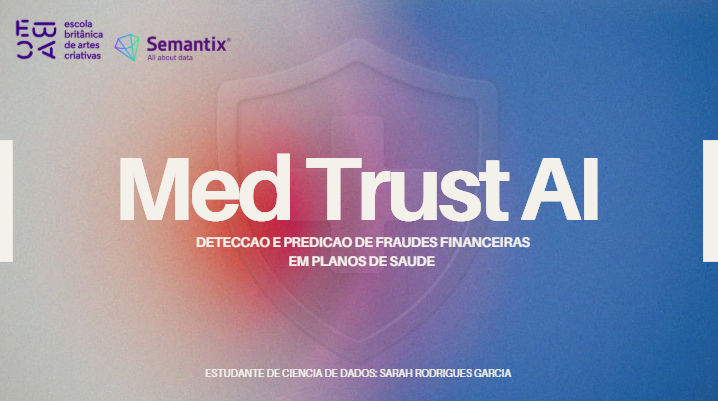

# **MedTrustAI - 🏥 Projeto de Detecção de Fraudes em Transações Financeiras de Planos de Saúde** (EBAC + SEMANTIX )

# **Sumário:**
O MED AI é um projeto de Machine Learning aplicado à detecção das três fraudes mais incidentes em financeiras de Planos de Saúde: Phantom Billing, Upcoding e Duplicidade de Pagamento. O objetivo é desenvolver um algoritmo rápido, assertivo e escalável capaz de identificar padrões fraudulentos em dados de planos de saúde, unindo informações financeiras e clínicas operacionais em um Data Lake integrado para detecção.

O projeto utiliza técnicas de engenharia de dados, balanceamento (SMOTE) e modelos de aprendizado supervisionado, com foco nos algoritmos LigthGBM e XGBoost, escolhidos por sua eficiência, robustez e capacidade de lidar com relações não lineares entre variáveis.

A pipeline desenvolvida permite a análise das transações em tempo quase real, possibilitando que o modelo identifique e sinalize potenciais fraudes com agilidade e precisão. É importante ressaltar que, as transações fraudulentas de Upcoding e Duplicidade são detectadas de forma em tempo real, já as fraudes de Phantom Billing por estarem diretamente associadas a comparação das datas de solicitação e realização apresentam margens de tempo de detecção de aproximadamente 1-3 meses para procedimentos de baixa e media complexidade e 6 -12 meses para procedimentos de alta complexidade.

**DIVIDIDO EM TRÊS PARTES PRINCIPAIS: COLETA DE DADOS, MODELAGEM E CONCLUSÃO.**

# **1. COLETA DE DADOS**

**Contexto da Situação:**

 O projeto tem como objetivo identificar fraudes em transações médicas. Essas fraudes estão distribuídas em **dois sistemas distintos:**

 - **Banco de Dados Financeiro do Plano de Saúde:** contém as informações de pagamentos, valores, datas, prestadores, métodos de repasse, etc.
 - **Banco de Dados Operacional Prestadores de Saúde:** contém os dados clínicos, autorizações, códigos de procedimentos, beneficiários e prestadores.

Para que o modelo de Machine Learning consiga avaliar a transação como um todo, **é essencial unir os aspectos mais importantes  desses dois conjuntos de dados** em um novo Banco de Dados, através de um **Data Lake.** Sobre a configuração do Data Lake e mais explicações detalhadas sobre a Integração de Banco de Dados, veja o Documento Tecnico Descritivo do MED AI, Link=##).

 Para o desenvolvimento deste projeto, foi realizada uma pesquisa por bancos de dados operacionais e financeiros que se aproximassem o máximo possível da realidade do setor de saúde. No entanto, devido às restrições impostas pela **Lei Geral de Proteção de Dados (LGPD)** e à **escassez de informações financeiras públicas sobre transações médicas,** optei pela criação de um **Banco de Dados Sintético.**

 Esse banco foi estruturado de forma a reproduzir de **maneira fiel a dinâmica e a complexidade dos dados que seriam integrados ao Data Lake em um ambiente real.**

 Aproximadamente 10 % de todas as transações em planos de saude são de caracteristica fraudulenta, sendo **as três mais incidentes: Cobranças Fantasmas (Phantom Billing), Consultas
 cobradas com valore superiores ao esperado (Upcoding) e Duplicidade de Pagamento.**


 O Banco Sintético foi criado com as seguintes porcentagens:

n = 10000  # total de registros - 90% regular

fraude_pct = 0.10 - 10% de fraudes

phantom_pct = 0.0333 - 3 % de Phantom Billing

upcoding_pct = 0.0333 - 3% de Upcoding

duplicidade_pct = 0.0333 - 3% de Duplicidade de Pagamento

 Aqui, teve-se de realizar **Engenharia reversa,** visando causar essa injeção de fraudes dentro do banco de dados, essa injeção fraudulenta acontece pela indicação de variáveis da seguinte forma:

- Phantom Billing - Criado pela comparação de valor_pago > 0 e data_realizacao = NaT


- Upcoding - Criado apartir da comparação status_saude = -1 (saudável) + procedimentos_urgencia = 'sim' (Aqui também seria algo novo dentro das avaliações de saúde, a marcação do estado de saúde segundo o primeiro contato de atendimento médico)


- Duplicidade de cobrança - valor_pago muito alto.

📌 É importante destacar um ponto relevante: a coluna **Status de Saúde** representa uma variável fundamental para a **detecção de fraudes.**
Atualmente, não existe nos sistemas operacionais de atendimento médico um campo que registre explicitamente o nível de saúde do paciente no momento do atendimento.

Na prática, durante a triagem, **o paciente é classificado apenas por critérios visuais (como pulseiras de cores diferentes)**, que indicam a gravidade ou urgência do caso — **porém, essas informações não são armazenadas digitalmente nos bancos de dados clínicos.**

 **O objetivo proposto neste projeto é que, a cada triagem e atendimento, essa informação seja registrada de forma estruturada e associada ao histórico clínico do paciente.**
Assim, o nível de saúde passaria a compor os arquivos do Data Lake, **contribuindo para análises mais precisas e para a detecção automatizada de inconsistências e possíveis fraudes nos procedimentos realizados.**


## **A. Geração de Base de Dados Sintética Fraudulentas**


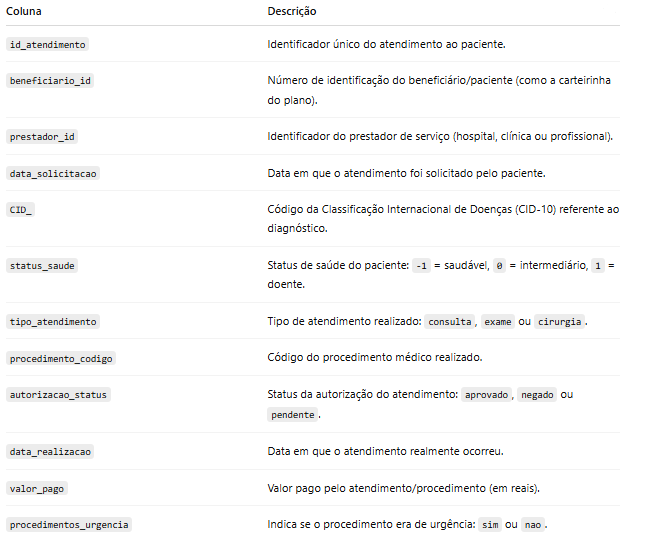

📌 No Data Lake, não serão incluídas as colunas indicadoras de fraude (Base de Teste). Porém,
é fundamental que a Base de Treinamento contenha a coluna de indicação de fraude, assim como a coluna de transações regulares, permitindo que o modelo de Machine Learning aprenda a diferenciar padrões legítimos e fraudulentos.
Essa limitação de padroe fraudulentos, será feita apartir de AED, Análise Explorarotia de Dados, seguindo valores estatisticos do que seriam os comportamentos regulares.

# CODIGO DE CRIAÇÃO EM FORMATO MARKDOWN:

import pandas as pd
import numpy as np
import random
from datetime import datetime, timedelta

# Parâmetros
n = 10000  # total de registros
fraude_pct = 0.10
phantom_pct = 0.0333
upcoding_pct = 0.0333
duplicidade_pct = 0.0333

# Seed para reprodutibilidade
np.random.seed(42)

# Função auxiliar
def random_date(start, end):
    return start + timedelta(days=random.randint(0, (end - start).days))

# Gerar dados base
df = pd.DataFrame({
    'id_atendimento': range(1, n + 1),
    'beneficiario_id': np.random.randint(1000, 9999, size=n),
    'prestador_id': np.random.randint(100, 999, size=n),
    'data_solicitacao': [random_date(datetime(2023, 1, 1), datetime(2024, 12, 31)) for _ in range(n)],
    'CID_': np.random.choice(['A00', 'B20', 'C34', 'D50', 'E11', 'F32', 'G40', 'H10', 'I10'], size=n),
    'status_saude': np.random.choice([-1, 0, 1], size=n, p=[0.4, 0.4, 0.2]),
    'tipo_atendimento': np.random.choice(['consulta', 'exame', 'cirurgia'], size=n, p=[0.6, 0.3, 0.1]),
    'procedimento_codigo': np.random.randint(10000, 99999, size=n),
    'autorizacao_status': np.random.choice(['aprovado', 'negado', 'pendente'], size=n, p=[0.7, 0.1, 0.2]),
    'data_realizacao': [random_date(datetime(2023, 1, 2), datetime(2025, 1, 1)) for _ in range(n)],
    'valor_pago': np.round(np.random.uniform(50, 1000, size=n), 2),
    'procedimentos_urgencia': np.random.choice(['sim', 'nao'], size=n, p=[0.2, 0.8])
})

#Injeção de Colunas Frauduletas:

# Inicializar colunas de fraude
df['phantom_billing'] = 0
df['upcoding'] = 0
df['duplicidade_pagamento'] = 0

#  Phantom Billing (valor_pago > 0 e data_realizacao = NaT)
phantom_idx = df.sample(frac=phantom_pct).index
df.loc[phantom_idx, 'data_realizacao'] = pd.NaT
df.loc[phantom_idx, 'phantom_billing'] = 1

# Upcoding (paciente saudável que recebeu urgência sem necessidade)
upcoding_idx = df[
    (df['status_saude'] == -1) & (df['procedimentos_urgencia'] == 'nao')
].sample(frac=upcoding_pct / 0.4, random_state=42).index  # ajusta a proporção dentro dos saudáveis
df.loc[upcoding_idx, 'procedimentos_urgencia'] = 'sim'
df.loc[upcoding_idx, 'upcoding'] = 1

# Duplicidade de cobrança (valor pago multiplicado)
duplicidade_idx = df.sample(frac=duplicidade_pct, random_state=42).index
df.loc[duplicidade_idx, 'valor_pago'] *= np.random.uniform(3, 5, size=len(duplicidade_idx))
df.loc[duplicidade_idx, 'duplicidade_pagamento'] = 1

# Criar a coluna 'regular' (1 = normal, 0 = fraude)
df['regular'] = np.where(
    df[['phantom_billing', 'upcoding', 'duplicidade_pagamento']].any(axis=1),
    0,  # fraude
    1   # regular
)

# Exibir amostra
print("Amostra de dados gerados com fraudes:")
print(df.head())

# Salvar CSV
csv_filename = "banco_dados_sintetico_operadora.csv"
df.to_csv(csv_filename, index=False)

# Baixar (somente no Google Colab)
try:
    from google.colab import files
    files.download(csv_filename)
except:
    print(f"Arquivo salvo localmente: {csv_filename}")

print("\nResumo das fraudes geradas:")
print(df[['phantom_billing', 'upcoding', 'duplicidade_pagamento']].sum())


In [1]:
#Codigo em forma de Comentario:

#import pandas as pd
#import numpy as np
#import random
#from datetime import datetime, timedelta

# Parâmetros
#n = 10000  # total de registros
#fraude_pct = 0.10
#phantom_pct = 0.0333
#upcoding_pct = 0.0333
#duplicidade_pct = 0.0333

# Seed para reprodutibilidade
#np.random.seed(42)

# Função auxiliar
#def random_date(start, end):
    #return start + timedelta(days=random.randint(0, (end - start).days))

# Gerar dados base
#df = pd.DataFrame({
    #'id_atendimento': range(1, n + 1),
    #'beneficiario_id': np.random.randint(1000, 9999, size=n),
    #'prestador_id': np.random.randint(100, 999, size=n),
    #'data_solicitacao': [random_date(datetime(2023, 1, 1), datetime(2024, 12, 31)) for _ in range(n)],
    #'CID_': np.random.choice(['A00', 'B20', 'C34', 'D50', 'E11', 'F32', 'G40', 'H10', 'I10'], size=n),
    #'status_saude': np.random.choice([-1, 0, 1], size=n, p=[0.4, 0.4, 0.2]),
    #'tipo_atendimento': np.random.choice(['consulta', 'exame', 'cirurgia'], size=n, p=[0.6, 0.3, 0.1]),
    #'procedimento_codigo': np.random.randint(10000, 99999, size=n),
    #'autorizacao_status': np.random.choice(['aprovado', 'negado', 'pendente'], size=n, p=[0.7, 0.1, 0.2]),
    #'data_realizacao': [random_date(datetime(2023, 1, 2), datetime(2025, 1, 1)) for _ in range(n)],
    #'valor_pago': np.round(np.random.uniform(50, 1000, size=n), 2),
    #'procedimentos_urgencia': np.random.choice(['sim', 'nao'], size=n, p=[0.2, 0.8])
#})

#Injeção de Colunas Frauduletas:

# Inicializar colunas de fraude
#df['phantom_billing'] = 0
#df['upcoding'] = 0
#df['duplicidade_pagamento'] = 0

#  Phantom Billing (valor_pago > 0 e data_realizacao = NaT)
#phantom_idx = df.sample(frac=phantom_pct).index
#df.loc[phantom_idx, 'data_realizacao'] = pd.NaT
#df.loc[phantom_idx, 'phantom_billing'] = 1

# Upcoding (paciente saudável que recebeu urgência sem necessidade)
#upcoding_idx = df[
    #(df['status_saude'] == -1) & (df['procedimentos_urgencia'] == 'nao')
#].sample(frac=upcoding_pct / 0.4, random_state=42).index  # ajusta a proporção dentro dos saudáveis
#df.loc[upcoding_idx, 'procedimentos_urgencia'] = 'sim'
#df.loc[upcoding_idx, 'upcoding'] = 1

# Duplicidade de cobrança (valor pago multiplicado)
#duplicidade_idx = df.sample(frac=duplicidade_pct, random_state=42).index
#df.loc[duplicidade_idx, 'valor_pago'] *= np.random.uniform(3, 5, size=len(duplicidade_idx))
#df.loc[duplicidade_idx, 'duplicidade_pagamento'] = 1

# Criar a coluna 'regular' (1 = normal, 0 = fraude)
#df['regular'] = np.where(
    #df[['phantom_billing', 'upcoding', 'duplicidade_pagamento']].any(axis=1),
    #0,  # fraude
    #1   # regular
#)

# Exibir amostra
#print("Amostra de dados gerados com fraudes:")
#print(df.head())

# Salvar CSV
#csv_filename = "banco_dados_sintetico_operadora.csv"
#df.to_csv(csv_filename, index=False)

# Baixar (somente no Google Colab)
#try:
    #from google.colab import files
    #files.download(csv_filename)
#except:
    #print(f"Arquivo salvo localmente: {csv_filename}")

#print("\nResumo das fraudes geradas:")
#print(df[['phantom_billing', 'upcoding', 'duplicidade_pagamento']].sum())


- Output do Banco de Dados:
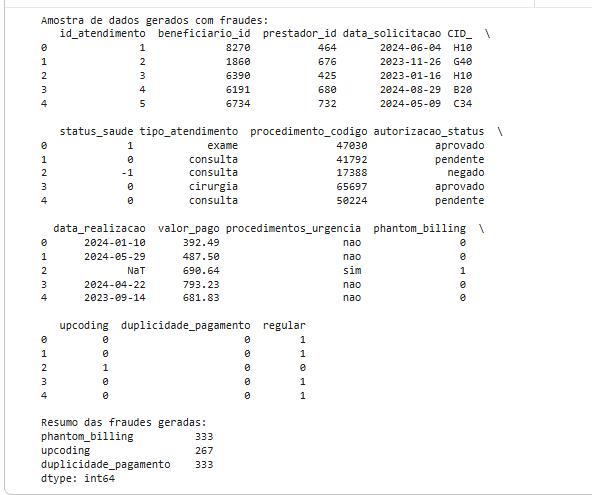

***OBSERVAÇÃO IMPORTANTE:*** "A cada execução deste primeiro bloco de código, é criado um DataFrame específico com aleatoriedade controlada entre os dados, preservando, entretanto, os registros fraudulentos. Para o projeto, é fundamental utilizar o CSV fornecido no repositório; caso contrário, toda a análise exploratória de dados (AED) não refletirá corretamente os dados do arquivo em questão."

Após a criação do banco de dados, foram adicionados padrões de fraude intencionalmente projetados para refletir situações reais de transações médicas e financeiras; Fator controlado que permite também testar a eficácia dos modelos de detecção.

## **B. Exploração do Banco de Dados**

Apesar de alguns pontos importantes de visualização já serem conhecidos (desbalanceamento de transações regulares e irregulares e proporções de fraudes), vou manter a visualização desses topicos por fator de cumprir a Análise Exploratória de Dados.

Abrir CSV: banco_dados_sintetico_operadora.csv

Disponível no Repositório.



In [2]:
import pandas as pd
import numpy as np
import random
from datetime import datetime, timedelta

df = pd.read_csv('banco_dados_sintetico_operadora.csv')
df.head()

,id_atendimento,beneficiario_id,prestador_id,data_solicitacao,CID_,status_saude,tipo_atendimento,procedimento_codigo,autorizacao_status,data_realizacao,valor_pago,procedimentos_urgencia,phantom_billing,upcoding,duplicidade_pagamento,regular
0,1,8270,464,2024-06-04,H10,1,exame,47030,aprovado,2024-01-10,392.49,nao,0,0,0,1
1,2,1860,676,2023-11-26,G40,0,consulta,41792,pendente,2024-05-29,487.50,nao,0,0,0,1
2,3,6390,425,2023-01-16,H10,-1,consulta,17388,negado,NaN,690.64,sim,1,1,0,0
3,4,6191,680,2024-08-29,B20,0,cirurgia,65697,aprovado,2024-04-22,793.23,nao,0,0,0,1
4,5,6734,732,2024-05-09,C34,0,consulta,50224,pendente,2023-09-14,681.83,nao,0,0,0,1


Verificar se o repositório acima bate com os dados desse repositório abaixo:

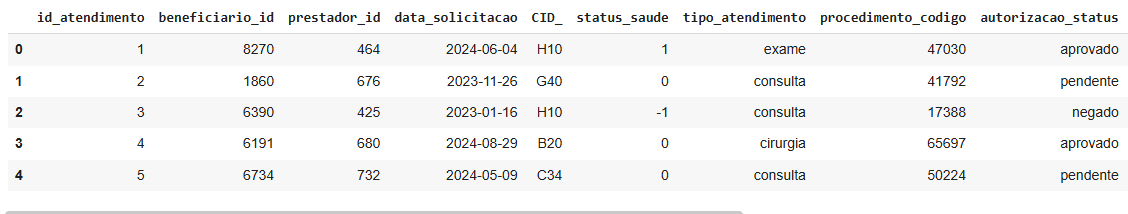

Inicialmente, o banco de dados será analisado sem considerar as colunas que indicam fraudes, com o objetivo de compreender o comportamento legítimo das transações médicas. A partir dessa análise exploratória, serão definidos novos limiares estatísticos que servirão como referência para a detecção de anomalias.

**Embora o banco de dados tenha sido gerado de forma sintética, contendo rótulos e limites fraudulentos previamente definidos, optou-se por desconsiderar essas marcações na etapa inicial. Dessa forma, a Análise Exploratória de Dados (AED) será conduzida de maneira independente, buscando identificar padrões e comportamentos suspeitos de forma legítima e imparcial, permitindo a redefinição dos critérios de detecção de fraude com base em evidências observadas nos próprios dados.**

In [3]:
df_eda = df.drop(columns=['phantom_billing', 'upcoding', 'duplicidade_pagamento', 'regular'])

# Salvar em CSV - Controle de Data Leak das colunas target
df_eda.to_csv('df_eda_limpo.csv', index=False)


In [4]:
df_eda = pd.read_csv('df_eda_limpo.csv')
df_eda.head()

,id_atendimento,beneficiario_id,prestador_id,data_solicitacao,CID_,status_saude,tipo_atendimento,procedimento_codigo,autorizacao_status,data_realizacao,valor_pago,procedimentos_urgencia
0,1,8270,464,2024-06-04,H10,1,exame,47030,aprovado,2024-01-10,392.49,nao
1,2,1860,676,2023-11-26,G40,0,consulta,41792,pendente,2024-05-29,487.50,nao
2,3,6390,425,2023-01-16,H10,-1,consulta,17388,negado,NaN,690.64,sim
3,4,6191,680,2024-08-29,B20,0,cirurgia,65697,aprovado,2024-04-22,793.23,nao
4,5,6734,732,2024-05-09,C34,0,consulta,50224,pendente,2023-09-14,681.83,nao


📌 Visão Geral:

In [5]:
df_eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id_atendimento          10000 non-null  int64  
 1   beneficiario_id         10000 non-null  int64  
 2   prestador_id            10000 non-null  int64  
 3   data_solicitacao        10000 non-null  object 
 4   CID_                    10000 non-null  object 
 5   status_saude            10000 non-null  int64  
 6   tipo_atendimento        10000 non-null  object 
 7   procedimento_codigo     10000 non-null  int64  
 8   autorizacao_status      10000 non-null  object 
 9   data_realizacao         9667 non-null   object 
 10  valor_pago              10000 non-null  float64
 11  procedimentos_urgencia  10000 non-null  object 
dtypes: float64(1), int64(5), object(6)
memory usage: 937.6+ KB


📌 Estatistica do Banco de Dados:

In [6]:
df_eda.describe()

,id_atendimento,beneficiario_id,prestador_id,status_saude,procedimento_codigo,valor_pago
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000
mean,5000.50000,5462.898000,551.032100,-0.196000,55003.15610,578.140900
std,2886.89568,2589.212679,261.488854,0.749827,25933.36648,431.869492
min,1.00000,1001.000000,100.000000,-1.000000,10001.00000,50.260000
25%,2500.75000,3217.000000,323.000000,-1.000000,32669.75000,297.420000
50%,5000.50000,5477.000000,552.000000,0.000000,55248.00000,547.355000
75%,7500.25000,7698.000000,780.000000,0.000000,77216.25000,784.790000
max,10000.00000,9998.000000,998.000000,1.000000,99994.00000,4871.538276


In [7]:
df_eda['data_solicitacao'].describe()

,data_solicitacao
count,10000
unique,731
top,2023-12-17
freq,27


*Insight sobre o dataset:*

- **Data de Solicitação:** Observa-se uma concentração significativa de atendimentos
no dia 2023-12-17. Data que pode indicar maior probabilidade de incidencia de fraudes.

- **Status de Saúde:** A maioria dos atendimentos (75%) está relacionada a pacientes com status de saúde intermediário, sugerindo predominância de casos não extremos.

- **Data de Realização:** Nota-se um pico de atendimentos em 02/07/2024, o que pode concentrar transações potencialmente fraudulentas nessa data.

- **Valor Pago:**

 Média: 578,14

 Mediana (50%): 547,35, próximo da média

 75º percentil: 784,79

 Máximo: 4.871,53, indicando possível outlier

 Desvio padrão: 431,86

 Valores muito acima da média podem ser considerados red flags, especialmente para identificar possíveis fraudes por duplicidade ou Phantom Billing.

In [8]:
df_eda.describe(include='object')

,data_solicitacao,CID_,tipo_atendimento,autorizacao_status,data_realizacao,procedimentos_urgencia
count,10000,10000,10000,10000,9667,10000
unique,731,9,3,3,731,2
top,2023-12-17,D50,consulta,aprovado,2023-07-11,nao
freq,27,1148,6052,6999,26,7768


**- CID:** O CID-10 mais frequente D50 refere-se a: “Anemia por deficiência de ferro”, o quê pode-se associar a má alimentação da população em questão, CID de nivel intermediário de atendimento.

**-Autorização de Saúde:** Aproximadamente 70% das transações foram aprovadas. Baixa recusa de cartão, aqui o fator chargeback(estorno de valor em cartão) também poderia ser analisado para detectar outros tipos de fraudes.

**-Procedimentos de Urgencia:** Aproximadamente 78% dos procedimentos não são de urgência, o que está coerente com a porcentagem de status de saúde.



*Insigth:* Todos os dados estão preenchidos, a unica coluna que apresenta dados nulos é a coluna de DateTime; Nesse caso é importante  mante-la porque ela se relaciona com a definição de comportamento fraudulento de Phantom Billing. Phantom Billing (valor_pago > 0 e data_realizacao = NaT)

**📌 Criando Limiar Fraudulento Phantom Billing:**

In [9]:
#Todos os valores de pago estão preenchidos, logo um indicado de Phantom Billing pode ser o procedimento solicitado, pago e não feito.
procedimentos_nao_realizados = df_eda[df_eda['data_realizacao'].isna()]
print(' Qnts de Procedimentos pagos e não realizados:', len(procedimentos_nao_realizados))

 Qnts de Procedimentos pagos e não realizados: 333


In [10]:
#Porcentagem de Phantom Billing:
procedimentos_nao_realizados = df_eda[df_eda['data_realizacao'].isna()]
porcentagem_pb = len(procedimentos_nao_realizados)/len(df_eda)*100
print(' Qnts de Procedimentos pagos e não realizados:', porcentagem_pb)

 Qnts de Procedimentos pagos e não realizados: 3.3300000000000005


In [11]:
# Como será indicado o fator de Phantom Billing : data de agendamento, valor pago e não realização do procedimento será considerado phantom billing:

# Garantir que as colunas de data estão no formato datetime
df_eda['data_solicitacao'] = pd.to_datetime(df['data_solicitacao'], errors='coerce')
df_eda['data_realizacao'] = pd.to_datetime(df['data_realizacao'], errors='coerce')

# Garantir que valor_pago é numérico (por precaução)
df_eda['valor_pago'] = pd.to_numeric(df['valor_pago'], errors='coerce').fillna(0)

# Condição de Phantom Billing:
# - valor_pago > 0  (houve pagamento)
# - data_solicitacao existe (não nula)
# - data_realizacao ausente (NaT)
df_eda['phantom_billing'] = np.where(
    (df_eda['valor_pago'] > 0) &
    (df_eda['data_solicitacao'].notna()) &
    (df_eda['data_realizacao'].isna()),
    1,  # é phantom
    0   # não é
)

# Contagem de procedimentos pagos e não realizados
qtd_procedimentos_pago_nao_realizados = int(df_eda['phantom_billing'].sum())
print('Qtd de Procedimentos pagos e não realizados:', qtd_procedimentos_pago_nao_realizados)

# Exibir alguns exemplos
df_eda[df_eda['phantom_billing'] == 1].head()

df_eda['phantom_billing'] = df['phantom_billing']

# Criar uma nova versão do DataFrame com a coluna phantom_billing salva
df_eda1 = df_eda.copy()

# Verificar se a nova coluna foi salva corretamente
print(df_eda1.head())

# Salvar em CSV para garantir persistência
df_eda1.to_csv('df_eda1.csv', index=False)
print("Novo DataFrame df_eda1 com coluna Phantom Billing salvo com sucesso!")


Qtd de Procedimentos pagos e não realizados: 333
   id_atendimento  beneficiario_id  prestador_id data_solicitacao CID_  \
0               1             8270           464       2024-06-04  H10   
1               2             1860           676       2023-11-26  G40   
2               3             6390           425       2023-01-16  H10   
3               4             6191           680       2024-08-29  B20   
4               5             6734           732       2024-05-09  C34   

   status_saude tipo_atendimento  procedimento_codigo autorizacao_status  \
0             1            exame                47030           aprovado   
1             0         consulta                41792           pendente   
2            -1         consulta                17388             negado   
3             0         cirurgia                65697           aprovado   
4             0         consulta                50224           pendente   

  data_realizacao  valor_pago procedimentos_urgen

**📌 Insight visual sobre Phantom Billing:**

/tmp/ipython-input-308258848.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_dates.index.astype(str), y=top_dates.values, palette='Reds_r')


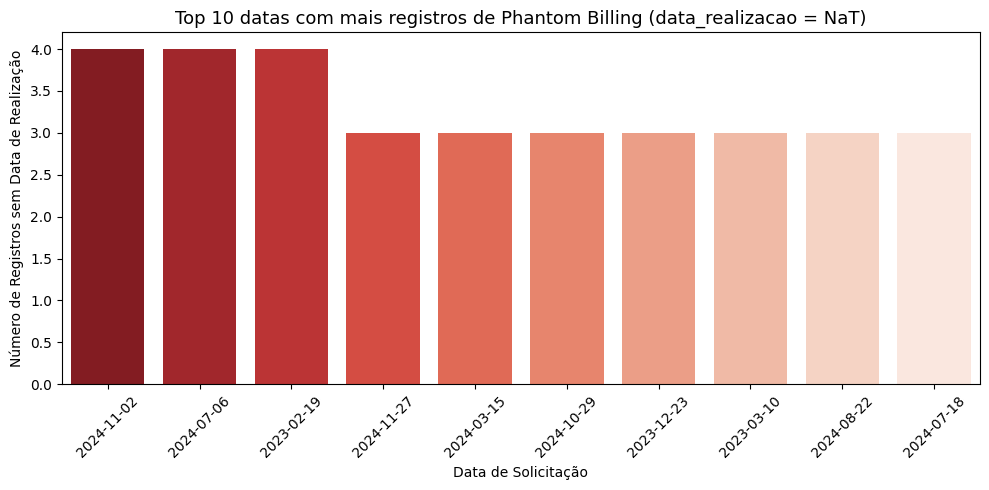

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Carregar e tratar as datas
df_eda = pd.read_csv("df_eda1.csv")
df_eda['data_solicitacao'] = pd.to_datetime(df_eda['data_solicitacao'], errors='coerce')
df_eda['data_realizacao'] = pd.to_datetime(df_eda['data_realizacao'], errors='coerce')

# Filtrar registros de Phantom Billing
phantom_df = df_eda[df_eda['data_realizacao'].isna()]

# Contagem de NaTs por data
nan_counts = phantom_df['data_solicitacao'].value_counts().sort_index()

# Selecionar top 10 datas com mais NaTs
top_dates = nan_counts.sort_values(ascending=False).head(10)

plt.figure(figsize=(10,5))
sns.barplot(x=top_dates.index.astype(str), y=top_dates.values, palette='Reds_r')
plt.title('Top 10 datas com mais registros de Phantom Billing (data_realizacao = NaT)', fontsize=13)
plt.xlabel('Data de Solicitação')
plt.ylabel('Número de Registros sem Data de Realização')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



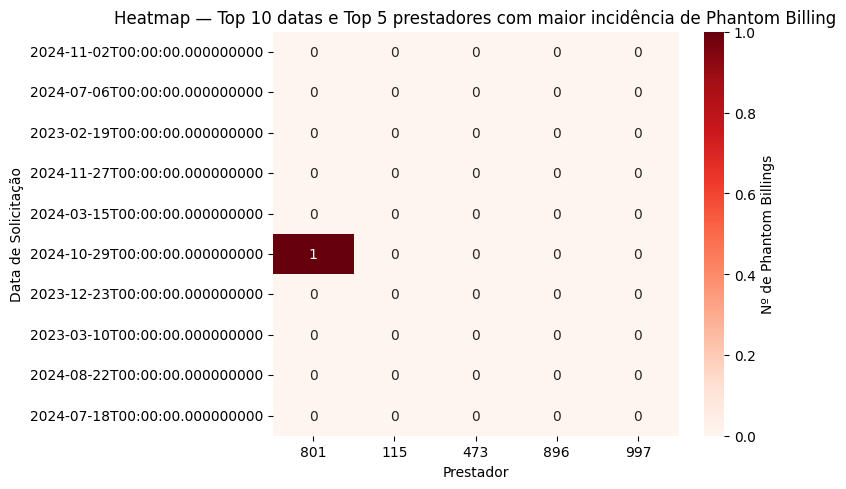

In [13]:
# Agrupar e montar a matriz
heatmap_data = (
    phantom_df.groupby(['data_solicitacao', 'prestador_id'])
    .size()
    .unstack(fill_value=0)
)

# Selecionar top 5 prestadores e top 10 datas
top_prestadores = heatmap_data.sum().sort_values(ascending=False).head(5).index
top_datas = heatmap_data.sum(axis=1).sort_values(ascending=False).head(10).index

heatmap_data_top = heatmap_data.loc[top_datas, top_prestadores]

plt.figure(figsize=(8,5))
sns.heatmap(heatmap_data_top, cmap='Reds', annot=True, fmt='.0f', cbar_kws={'label': 'Nº de Phantom Billings'})
plt.title('Heatmap — Top 10 datas e Top 5 prestadores com maior incidência de Phantom Billing', fontsize=12)
plt.xlabel('Prestador')
plt.ylabel('Data de Solicitação')
plt.tight_layout()
plt.show()


**📌 Criando Limiar Fraudulento Upcoding:**

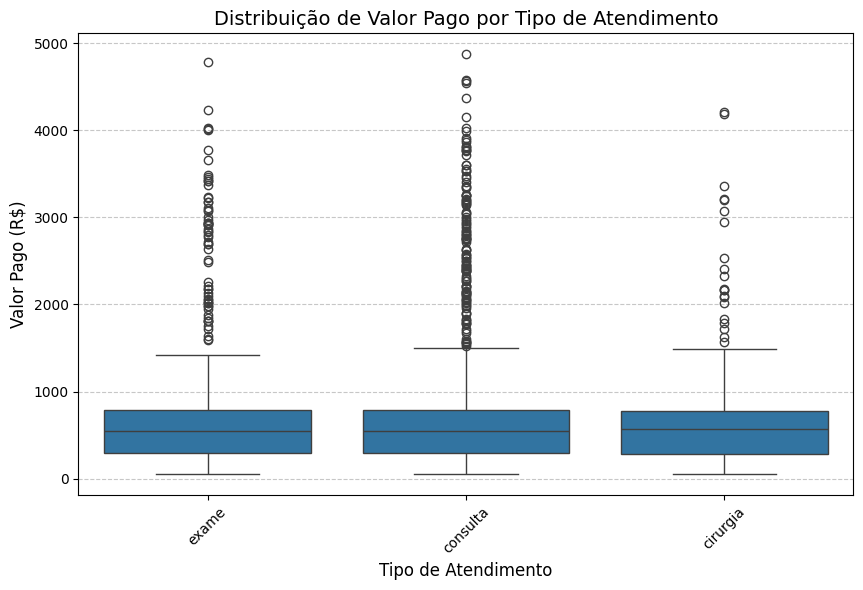

In [14]:
#Busca por Upcoding, verifica os tipos de atendimento e BoxPlots dos valores que foram pagos referentes a cada categoria de atendimento:

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.boxplot(x='tipo_atendimento', y='valor_pago', data=df_eda1)

plt.title('Distribuição de Valor Pago por Tipo de Atendimento', fontsize=14)
plt.xlabel('Tipo de Atendimento', fontsize=12)
plt.ylabel('Valor Pago (R$)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

*Insigth:* Geralmente, cirurgias são evidentemente mais caras que exames e consultas, observar outliers em exames e muitos valores altos em consultas podem ser tratados como redflags para possiveis fraudes, mas nesse caso apenas usar isso como limiar de provavel fraude não é suficiente já que cirurgias complexas realmente têm custos muito variáveis; pacientes graves podem gerar custos legítimos mais altos; prestadores diferentes cobram valores distintos pelo mesmo procedimento.

Vou usar essa logica para determinar upcoding para pacientes com Status de Saúde - SAUDAVEL (-1) :

Pacientes classificados como saudáveis (status_saude = -1) que apresentarem valores pagos acima do limite definido para sua categoria (EXAME, CONSULTA) foram marcados como suspeitos de Upcoding.
Além disso, para a categoria cirurgia, foi aplicado um teto máximo de R$ 3000, garantindo que valores legítimos como: cirurgias eletivas (ex.: estética ou preventiva); muito altos não sejam automaticamente classificados como fraude, a segunda regra de detecção de Upcoding será Pacientes saudáveis (status_saude == -1) que receberam procedimentos de urgência (tipo_atendimento == 'urgência').

In [15]:
import pandas as pd
import numpy as np

# Carregar a base
df_eda = pd.read_csv("df_eda1.csv")

# Garantir que valor_pago é numérico
df_eda['valor_pago'] = pd.to_numeric(df_eda['valor_pago'], errors='coerce').fillna(0)

# Criar coluna de Upcoding zerada
df_eda['upcoding'] = 0

# Criar dicionário com upper fence por tipo de atendimento
upper_fences = {}
for tipo in df_eda['tipo_atendimento'].unique():
    q1 = df_eda.loc[df_eda['tipo_atendimento'] == tipo, 'valor_pago'].quantile(0.25)
    q3 = df_eda.loc[df_eda['tipo_atendimento'] == tipo, 'valor_pago'].quantile(0.75)
    iqr = q3 - q1
    upper_fence = q3 + 1.5 * iqr

    # Limite máximo fixo para cirurgias, se desejar
    if tipo.lower().strip() == 'cirurgia':
        upper_fence = min(upper_fence, 3000)

    upper_fences[tipo] = upper_fence

# Detectar upcoding para pacientes saudáveis (-1) que receberam urgência
mask_upcoding = (
    ((df_eda['status_saude'] == -1) &
     (df_eda['tipo_atendimento'].str.lower().str.strip() == 'urgência'))
    |
    (df_eda['valor_pago'] > df_eda['tipo_atendimento'].map(upper_fences))
)

df_eda.loc[mask_upcoding, 'upcoding'] = 1

# Estatística rápida
print("Total de possíveis casos de Upcoding:", df_eda['upcoding'].sum())
print(df_eda[df_eda['upcoding'] == 1].head())

# Salvar em CSV
df_eda.to_csv('df_eda2.csv', index=False)
print("Novo DataFrame df_eda2 com coluna Upcoding salvo com sucesso!")



Total de possíveis casos de Upcoding: 211
    id_atendimento  beneficiario_id  prestador_id data_solicitacao CID_  \
31              32             8734           304       2023-07-04  A00   
35              36             4890           542       2024-05-29  B20   
39              40             9433           820       2024-10-24  C34   
80              81             3568           887       2023-11-22  I10   
88              89             6892           360       2023-05-03  C34   

    status_saude tipo_atendimento  procedimento_codigo autorizacao_status  \
31             0         consulta                10778           aprovado   
35            -1         consulta                13595           aprovado   
39             0         consulta                88723             negado   
80             1         consulta                31584           aprovado   
88             0            exame                33845           aprovado   

   data_realizacao   valor_pago procedimento

In [16]:
#Carregar a Base
df_eda2 = pd.read_csv("df_eda2.csv")
df_eda2.head()

,id_atendimento,beneficiario_id,prestador_id,data_solicitacao,CID_,status_saude,tipo_atendimento,procedimento_codigo,autorizacao_status,data_realizacao,valor_pago,procedimentos_urgencia,phantom_billing,upcoding
0,1,8270,464,2024-06-04,H10,1,exame,47030,aprovado,2024-01-10,392.49,nao,0,0
1,2,1860,676,2023-11-26,G40,0,consulta,41792,pendente,2024-05-29,487.50,nao,0,0
2,3,6390,425,2023-01-16,H10,-1,consulta,17388,negado,NaN,690.64,sim,1,0
3,4,6191,680,2024-08-29,B20,0,cirurgia,65697,aprovado,2024-04-22,793.23,nao,0,0
4,5,6734,732,2024-05-09,C34,0,consulta,50224,pendente,2023-09-14,681.83,nao,0,0


In [17]:
#Ver contagem de Upcoding:
porcentagem_upcoding = df_eda2['upcoding'].sum()/len(df_eda2)*100
print('Porcentagem de Upcoding:', porcentagem_upcoding, '%')

Porcentagem de Upcoding: 2.11 %


**📌 Criando Limiar Fraudulento Duplicidade de Pagamento:**

As duas regras para esse limiar serão valores em duas vezes acima da mediana e transações duplicadas para um mesmo beneficiario no mesmo dia.

In [18]:
#Busca por Duplicidade de Pagamento:

import pandas as pd
import numpy as np
from datetime import datetime

#Carregar a Base
df_eda = pd.read_csv("df_eda2.csv")

# Garantir que valor_pago é numérico
df_eda['valor_pago'] = pd.to_numeric(df_eda['valor_pago'], errors='coerce').fillna(0)

# Criar Coluna zerada de Duplicidade de Pagamento
df_eda['duplicidade'] = 0

# Regra1: Verificar os tipos de atendimento e buscar suas medianas:
for tipo in df_eda['tipo_atendimento'].unique(): #aqui delimitações dos tipos em (tipo) para o subset e então calculo da mediana.
  subset = df_eda[df_eda['tipo_atendimento']== tipo] #subgrupo com dados que estão na coluna igual a tipo.
  mediana = subset['valor_pago'].median()
  limite_duplicidade = 2*mediana

  #Condição de Duplicidade:
  cond_dup = (df_eda['tipo_atendimento'] == tipo) & (df_eda['valor_pago']> limite_duplicidade)

  df_eda.loc[cond_dup,'duplicidade'] = 1

#Regra 2: Sobre transações duplicadas no mesmo dia para um mesmo beneficiario

df_eda['data_solicitacao'] = pd.to_datetime(df_eda['data_solicitacao'], errors = 'coerce')

# Atualizar apenas os registros duplicados
duplicados_idx = df_eda.duplicated(subset=['beneficiario_id', 'data_solicitacao'], keep=False)
df_eda.loc[duplicados_idx, 'duplicidade'] = 1

print('Quantidade de Transações Duplicadas:\n', df_eda['duplicidade'].sum())

# Salvar em CSV para garantir persistência
df_eda.to_csv('df_eda3.csv', index=False)
print("Novo DataFrame df_eda3 com coluna Duplicidade salvo com sucesso!")


Quantidade de Transações Duplicadas:
 278
Novo DataFrame df_eda3 com coluna Duplicidade salvo com sucesso!


In [19]:
#Porcentagem de Dados Duplicados no df:

porcentagem_pb = df_eda['duplicidade'].sum()/len(df_eda)*100
print('Porcentagem de Transações Duplicadas:', porcentagem_pb, '%')


Porcentagem de Transações Duplicadas: 2.78 %


In [20]:
df_eda.head()

,id_atendimento,beneficiario_id,prestador_id,data_solicitacao,CID_,status_saude,tipo_atendimento,procedimento_codigo,autorizacao_status,data_realizacao,valor_pago,procedimentos_urgencia,phantom_billing,upcoding,duplicidade
0,1,8270,464,2024-06-04,H10,1,exame,47030,aprovado,2024-01-10,392.49,nao,0,0,0
1,2,1860,676,2023-11-26,G40,0,consulta,41792,pendente,2024-05-29,487.50,nao,0,0,0
2,3,6390,425,2023-01-16,H10,-1,consulta,17388,negado,NaN,690.64,sim,1,0,0
3,4,6191,680,2024-08-29,B20,0,cirurgia,65697,aprovado,2024-04-22,793.23,nao,0,0,0
4,5,6734,732,2024-05-09,C34,0,consulta,50224,pendente,2023-09-14,681.83,nao,0,0,0


**📌 Visualização de Distribuição de valores Pagos:**

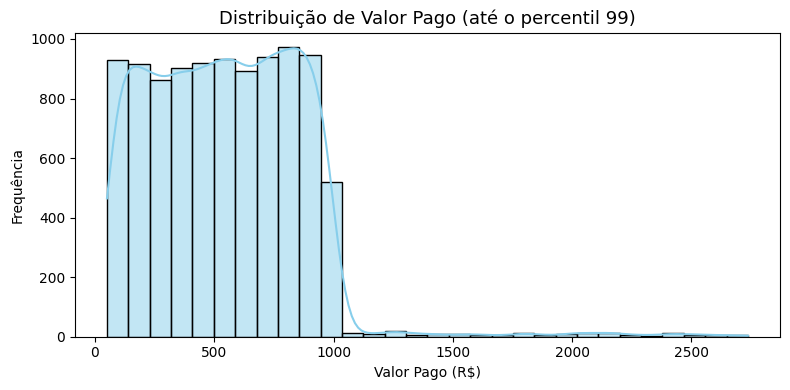

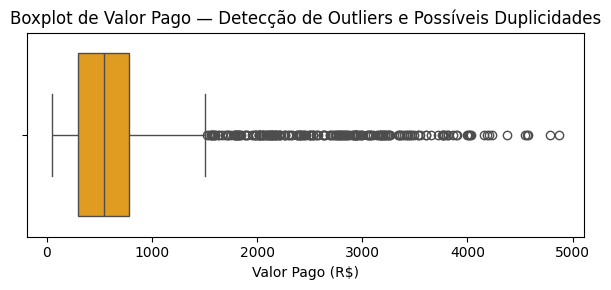

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Garantir tipo numérico
df['valor_pago'] = pd.to_numeric(df['valor_pago'], errors='coerce')

# Remover outliers extremos só para visualização mais limpa (opcional)
limite_superior = df['valor_pago'].quantile(0.99)
df_visual = df[df['valor_pago'] <= limite_superior]

# Histograma — distribuição geral de valores pagos
plt.figure(figsize=(8,4))
sns.histplot(df_visual['valor_pago'], bins=30, kde=True, color='skyblue')
plt.title('Distribuição de Valor Pago (até o percentil 99)', fontsize=13)
plt.xlabel('Valor Pago (R$)')
plt.ylabel('Frequência')
plt.tight_layout()
plt.show()

# Boxplot — identificação de outliers
plt.figure(figsize=(6,3))
sns.boxplot(x=df['valor_pago'], color='orange')
plt.title('Boxplot de Valor Pago — Detecção de Outliers e Possíveis Duplicidades', fontsize=12)
plt.xlabel('Valor Pago (R$)')
plt.tight_layout()
plt.show()


**📌 Marcação da Coluna Regular:**

O ML precisa entender as marcações de linhas fraudulentas para seu treinamento, é se então necessário a criação de coluna regular para a compreensão global de cada tipo de comportamento dentro do df.

In [22]:
#Criar coluna regular:

df_eda['regular'] = 1 # assumir toda coluna como regular

# Marcar como 0 se houver qualquer tipo de fraude
df_eda.loc[
    (df_eda['phantom_billing'] == 1) |
    (df_eda['upcoding'] == 1) |
    (df_eda['duplicidade'] == 1),
    'regular'
] = 0

# Salvar em CSV para garantir persistência
df_eda.to_csv('df_eda4.csv', index=False)

In [23]:
df_eda = pd.read_csv('df_eda4.csv')
df_eda.head()

,id_atendimento,beneficiario_id,prestador_id,data_solicitacao,CID_,status_saude,tipo_atendimento,procedimento_codigo,autorizacao_status,data_realizacao,valor_pago,procedimentos_urgencia,phantom_billing,upcoding,duplicidade,regular
0,1,8270,464,2024-06-04,H10,1,exame,47030,aprovado,2024-01-10,392.49,nao,0,0,0,1
1,2,1860,676,2023-11-26,G40,0,consulta,41792,pendente,2024-05-29,487.50,nao,0,0,0,1
2,3,6390,425,2023-01-16,H10,-1,consulta,17388,negado,NaN,690.64,sim,1,0,0,0
3,4,6191,680,2024-08-29,B20,0,cirurgia,65697,aprovado,2024-04-22,793.23,nao,0,0,0,1
4,5,6734,732,2024-05-09,C34,0,consulta,50224,pendente,2023-09-14,681.83,nao,0,0,0,1


**📌 Visualização dos tipos de Fraudes:**

/tmp/ipython-input-1804294118.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(fraude_counts.keys()), y=list(fraude_counts.values()), palette='coolwarm')


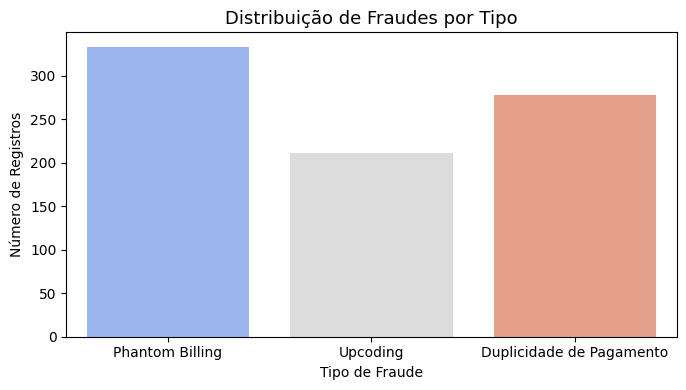

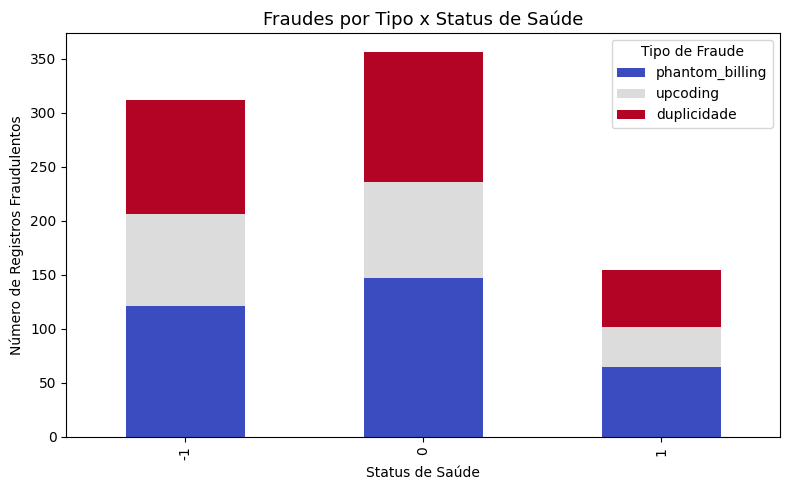

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Carregar dados
df = pd.read_csv('df_eda4.csv')

# Garantir tipo correto
df[['phantom_billing', 'upcoding', 'duplicidade']] = df[
    ['phantom_billing', 'upcoding', 'duplicidade']
].astype(int)

# Contagem total por tipo de fraude
fraude_counts = {
    'Phantom Billing': df['phantom_billing'].sum(),
    'Upcoding': df['upcoding'].sum(),
    'Duplicidade de Pagamento': df['duplicidade'].sum()
}

plt.figure(figsize=(7,4))
sns.barplot(x=list(fraude_counts.keys()), y=list(fraude_counts.values()), palette='coolwarm')
plt.title('Distribuição de Fraudes por Tipo', fontsize=13)
plt.ylabel('Número de Registros')
plt.xlabel('Tipo de Fraude')
plt.tight_layout()
plt.show()

# Stacked Barplot cruzando fraudes com status_saude
fraude_por_status = df.groupby('status_saude')[['phantom_billing', 'upcoding', 'duplicidade']].sum()

fraude_por_status.plot(kind='bar', stacked=True, figsize=(8,5), colormap='coolwarm')
plt.title('Fraudes por Tipo x Status de Saúde', fontsize=13)
plt.xlabel('Status de Saúde')
plt.ylabel('Número de Registros Fraudulentos')
plt.legend(title='Tipo de Fraude')
plt.tight_layout()
plt.show()


*Insigth:*
- FRAUDES POR TIPO GRAFICO: A Marcação de proporções
fraudulentas apresentaram valores bem próximos.
- FRAUDES POR TIPO X STATUS DE SAUDE: O Status de Saude que apresenta maior incidencia fraudulenta é o Status de Saude Intermediario, segudo do status saudável e em terceiro o estado grave de saude.





**📌 Distribuição de registros por data:**

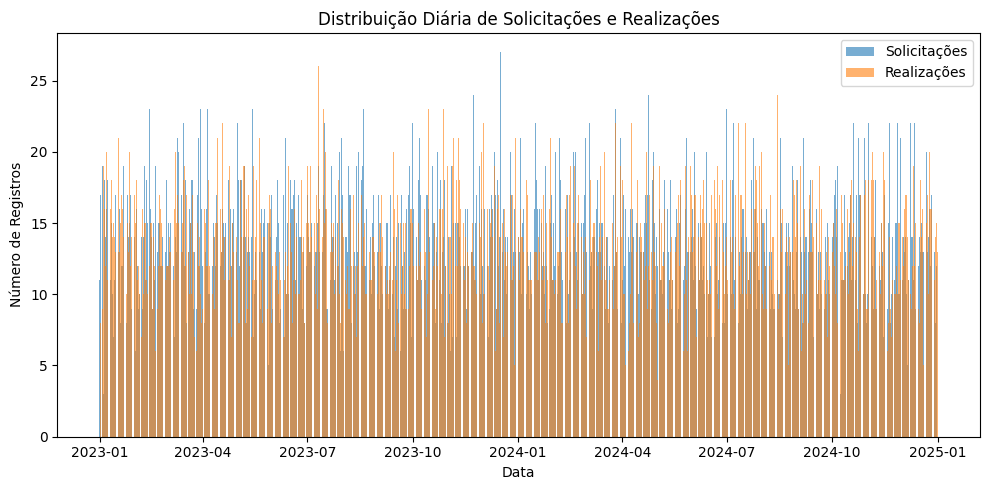

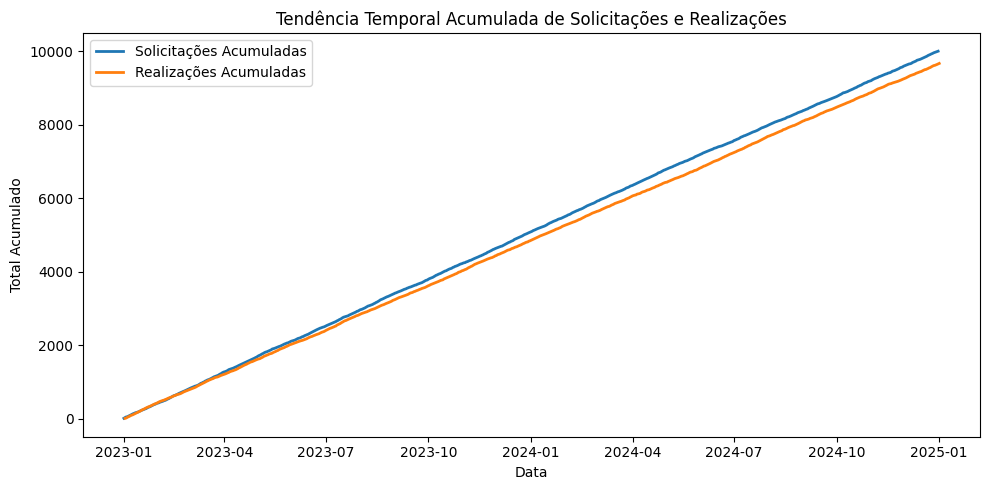

In [25]:
import pandas as pd
import matplotlib.pyplot as plt

# Carregar os dados
df = pd.read_csv('df_eda4.csv')

# Converter colunas de data
df['data_solicitacao'] = pd.to_datetime(df['data_solicitacao'], errors='coerce')
df['data_realizacao'] = pd.to_datetime(df['data_realizacao'], errors='coerce')

# Contagem diária de solicitações e realizações
solicitacoes_por_dia = df['data_solicitacao'].value_counts().sort_index()
realizacoes_por_dia = df['data_realizacao'].value_counts().sort_index()

# --- HISTOGRAMA/CONTAGEM DIÁRIA ---
plt.figure(figsize=(10,5))
plt.bar(solicitacoes_por_dia.index, solicitacoes_por_dia.values, alpha=0.6, label='Solicitações')
plt.bar(realizacoes_por_dia.index, realizacoes_por_dia.values, alpha=0.6, label='Realizações')
plt.title('Distribuição Diária de Solicitações e Realizações')
plt.xlabel('Data')
plt.ylabel('Número de Registros')
plt.legend()
plt.tight_layout()
plt.show()

# Gráfico de linha acumulativa (tendência temporal)
solicitacoes_acumuladas = solicitacoes_por_dia.cumsum()
realizacoes_acumuladas = realizacoes_por_dia.cumsum()

plt.figure(figsize=(10,5))
plt.plot(solicitacoes_acumuladas.index, solicitacoes_acumuladas.values, label='Solicitações Acumuladas', linewidth=2)
plt.plot(realizacoes_acumuladas.index, realizacoes_acumuladas.values, label='Realizações Acumuladas', linewidth=2)
plt.title('Tendência Temporal Acumulada de Solicitações e Realizações')
plt.xlabel('Data')
plt.ylabel('Total Acumulado')
plt.legend()
plt.tight_layout()
plt.show()


*Insigth*: As linhas de Solicitações e Realizações estão bem proximas, coeficientes angulares bem proximos... porém ha uma leve diferença que pode indicar o Phanton Billing, a linha de solicitação apresenta coeficiente angular levemente maior do que a linha de Realizações.

**📌 Distribuição de status de saúde:**

/tmp/ipython-input-3553942649.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='status_saude', data=df, palette='coolwarm', order=df['status_saude'].value_counts().index)


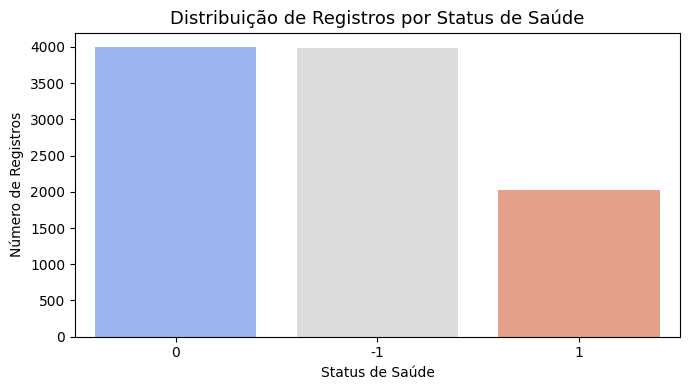

/tmp/ipython-input-3553942649.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='status_saude', y='valor_pago', data=df, palette='coolwarm')


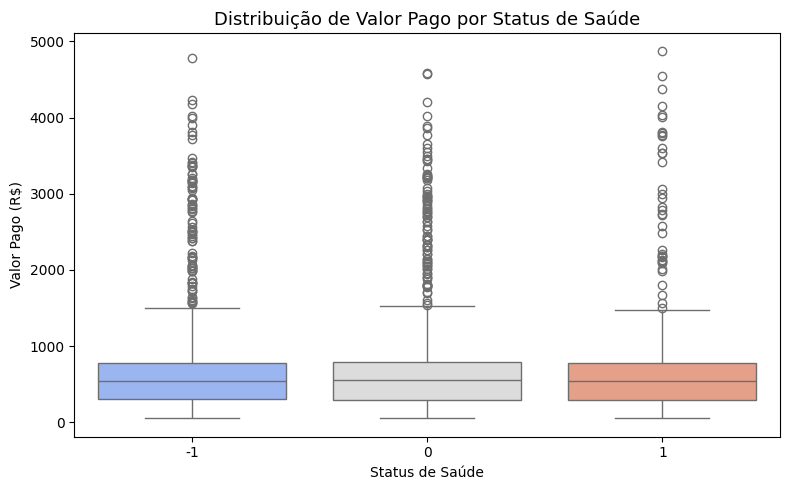

               count        mean         std    min          max
status_saude                                                    
-1            3983.0  576.795950  425.304661  50.26  4782.376911
 0            3994.0  580.753209  433.145250  50.70  4578.617717
 1            2023.0  575.631447  442.238618  50.86  4871.538276


In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Carregar dados
df = pd.read_csv('df_eda4.csv')

# Garantir tipos corretos
df['valor_pago'] = pd.to_numeric(df['valor_pago'], errors='coerce')

# 1️⃣ Distribuição de status de saúde
plt.figure(figsize=(7,4))
sns.countplot(x='status_saude', data=df, palette='coolwarm', order=df['status_saude'].value_counts().index)
plt.title('Distribuição de Registros por Status de Saúde', fontsize=13)
plt.xlabel('Status de Saúde')
plt.ylabel('Número de Registros')
plt.tight_layout()
plt.show()

# 2️⃣ Boxplot — relação entre valor pago e status de saúde
plt.figure(figsize=(8,5))
sns.boxplot(x='status_saude', y='valor_pago', data=df, palette='coolwarm')
plt.title('Distribuição de Valor Pago por Status de Saúde', fontsize=13)
plt.xlabel('Status de Saúde')
plt.ylabel('Valor Pago (R$)')
plt.tight_layout()
plt.show()

# 3️⃣ (Opcional) Estatísticas resumidas por status_saude
resumo = df.groupby('status_saude')['valor_pago'].describe()[['count','mean','std','min','max']]
print(resumo)


*Insigth:*
- Grafico de Registros de Saude: Pessoas desse banco de dados apresentam sua maior parcela em satus de saude saudável e intermediario.

- Grafico de Distribuição de Saude x Valor Pago: Os boxplots mostram que apesar dos status de saude se diferenciarem entre si, dentro dos valores pagos apresentam outliers relativamente proximos entre si. Algo que claramente demonstra a presença de um comportamento anormal em torno do status de saude/recomendação/consulta e valor pago.

#**2. MODELAGEM**

## **A. Pré Tratamento da Base de Dados** | **Data Preprocessing**

Não será realizado um pré-processamento complexo, com o objetivo de manter os dados o mais próximo possível da realidade e preservar sinais críticos de fraude.

O Objetivo do projeto é criar um ML capaz de detectar rapidamente transações financeiras fraudulentas. Como já sera necessária a realização de um join de banco de dados com grande volume da dados - algo que já requer certa complexidade computacional - os MLs escolhidos validação desse sistema precisam ser rapidos e não ter normalizaçao como fator obrigatorio para a predição de fraudes. Tendo em mente, os dois MLs escolhidos foram: Random Forest e XGBOOST.

In [27]:
df = pd.read_csv('df_eda4.csv')
df.head()

,id_atendimento,beneficiario_id,prestador_id,data_solicitacao,CID_,status_saude,tipo_atendimento,procedimento_codigo,autorizacao_status,data_realizacao,valor_pago,procedimentos_urgencia,phantom_billing,upcoding,duplicidade,regular
0,1,8270,464,2024-06-04,H10,1,exame,47030,aprovado,2024-01-10,392.49,nao,0,0,0,1
1,2,1860,676,2023-11-26,G40,0,consulta,41792,pendente,2024-05-29,487.50,nao,0,0,0,1
2,3,6390,425,2023-01-16,H10,-1,consulta,17388,negado,NaN,690.64,sim,1,0,0,0
3,4,6191,680,2024-08-29,B20,0,cirurgia,65697,aprovado,2024-04-22,793.23,nao,0,0,0,1
4,5,6734,732,2024-05-09,C34,0,consulta,50224,pendente,2023-09-14,681.83,nao,0,0,0,1


### **B. Correlação das Variaveis:**

Definir as variaveis mais importantes para o ML, de forma a retirar as variáveis que não implicam diretamente ao fator fraude no df. Para isso será realizar padronização dos dados, usando label enconder e one-hot-enconder;
 Variaveis e Target Fraudulenta não se relacionam de forma linear, logo será necessária uma valiação não linear das variaveis.

#### - id_atendimento

Será mantido, porque ela é que indica qual o numero do atendimento o qual é fraudulento.


#### - CID_,tipo_atendimento,procedimento_codigo,autorizacao_status,procedimentos_urgencia

Serão transformados com uso de label enconder.

In [28]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Carregar a base original
df = pd.read_csv("df_eda4.csv")

# Definir as colunas que precisam ser codificadas
cols_to_encode = ['CID_', 'tipo_atendimento', 'procedimento_codigo',
                  'autorizacao_status', 'procedimentos_urgencia']

# Criar um novo DataFrame (cópia de segurança)
df_encoded = df.copy()

# Aplicar LabelEncoder e substituir as colunas originais
for col in cols_to_encode:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))

# Verificar resultado
print("✅ Colunas codificadas com sucesso:")
print(df_encoded[cols_to_encode].head())

# Salvar o novo DataFrame
df_encoded.to_csv("df_encoded.csv", index=False)
print(" Novo DataFrame salvo como 'df_encoded.csv'")


✅ Colunas codificadas com sucesso:
   CID_  tipo_atendimento  procedimento_codigo  autorizacao_status  \
0     7                 2                 3877                   0   
1     6                 1                 3357                   2   
2     7                 1                  793                   1   
3     1                 0                 5863                   0   
4     2                 1                 4205                   2   

   procedimentos_urgencia  
0                       0  
1                       0  
2                       1  
3                       0  
4                       0  
 Novo DataFrame salvo como 'df_encoded.csv'


In [29]:
df = pd.read_csv("df_encoded.csv")
df.head()

,id_atendimento,beneficiario_id,prestador_id,data_solicitacao,CID_,status_saude,tipo_atendimento,procedimento_codigo,autorizacao_status,data_realizacao,valor_pago,procedimentos_urgencia,phantom_billing,upcoding,duplicidade,regular
0,1,8270,464,2024-06-04,7,1,2,3877,0,2024-01-10,392.49,0,0,0,0,1
1,2,1860,676,2023-11-26,6,0,1,3357,2,2024-05-29,487.50,0,0,0,0,1
2,3,6390,425,2023-01-16,7,-1,1,793,1,NaN,690.64,1,1,0,0,0
3,4,6191,680,2024-08-29,1,0,0,5863,0,2024-04-22,793.23,0,0,0,0,1
4,5,6734,732,2024-05-09,2,0,1,4205,2,2023-09-14,681.83,0,0,0,0,1


#### - Padronizando Data:

O código trata valores ausentes (NaN) substituindo-os por 0 antes da padronização, garantindo que o modelo de machine learning funcione corretamente sem erros. Além disso, esses valores zerados atuam como indicadores (“flags”) de possíveis inconsistências nas datas, o que é relevante para a detecção de fraudes, já que a ausência de informações temporais pode sinalizar registros suspeitos.

In [30]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Carregar CSV
df = pd.read_csv("df_encoded.csv")

# Criar colunas numéricas a partir das datas
df['data_solicitacao_num'] = pd.to_datetime(df['data_solicitacao'], errors='coerce').map(lambda x: x.toordinal() if pd.notnull(x) else 0)
df['data_realizacao_num'] = pd.to_datetime(df['data_realizacao'], errors='coerce').map(lambda x: x.toordinal() if pd.notnull(x) else 0)

# Padronizar as datas
scaler = StandardScaler()
df[['data_solicitacao_num', 'data_realizacao_num']] = scaler.fit_transform(df[['data_solicitacao_num', 'data_realizacao_num']])

# Remover as colunas originais de datas
df.drop(columns=['data_solicitacao', 'data_realizacao'], inplace=True)

# Conferir resultado
print(df[['data_solicitacao_num', 'data_realizacao_num']].head())

# Salvar DataFrame padronizado
df.to_csv("df_encoded_padronizado.csv", index=False)
print("\n DataFrame padronizado salvo (colunas originais de data removidas)!")



   data_solicitacao_num  data_realizacao_num
0              0.754615             0.185671
1             -0.153684             0.186727
2             -1.646907            -5.387946
3              1.163587             0.186448
4              0.630972             0.184781

 DataFrame padronizado salvo (colunas originais de data removidas)!


#### - Data de Realização (Atenção aos Nans)

Os Nans em data de realização possuem significado, eles fazem parte da  indicação de phantom billing, como é importante a presença deles dentro do banco de dados, será feito o seguinte: criação binaria de coluna indicando data_realizacao_flag_num: 1 - data presente e 0 - data Nan

**É importante ressaltar que o modelo consegue detectar automaticamente fraudes de upcoding e duplicidade de pagamento, para o phantom billing seria necessário a verificação dentro de 30 dias para procedimentos de baixa complexidade e de 6 meses a 1 ano para procedimentos de complexidade intermediária ou grave; De forma que a data de realização se cumpra, caso não se cumpra dentro desses limites de tempo, será definido como Phantom Billing.**

In [31]:
import pandas as pd

# Carregar CSV já padronizado e sem colunas originais
df = pd.read_csv('df_encoded_padronizado.csv')

# Criar cópia para preservar o original
df_final = df.copy()

# Criar flag numérica indicando se havia data de realização
# (0 = sem data original, 1 = data presente)
df_final['data_realizacao_flag_num'] = (df_final['data_realizacao_num'] != 0).astype(int)

# Conferir as primeiras linhas
print(df_final.head())

# Salvar novo DataFrame
df_final.to_csv("df_final.csv", index=False)
print("✅ Novo DataFrame salvo como 'df_final.csv'")


   id_atendimento  beneficiario_id  prestador_id  CID_  status_saude  \
0               1             8270           464     7             1   
1               2             1860           676     6             0   
2               3             6390           425     7            -1   
3               4             6191           680     1             0   
4               5             6734           732     2             0   

   tipo_atendimento  procedimento_codigo  autorizacao_status  valor_pago  \
0                 2                 3877                   0      392.49   
1                 1                 3357                   2      487.50   
2                 1                  793                   1      690.64   
3                 0                 5863                   0      793.23   
4                 1                 4205                   2      681.83   

   procedimentos_urgencia  phantom_billing  upcoding  duplicidade  regular  \
0                       0       

Enfim, correlação das variáveis de forma não linear.

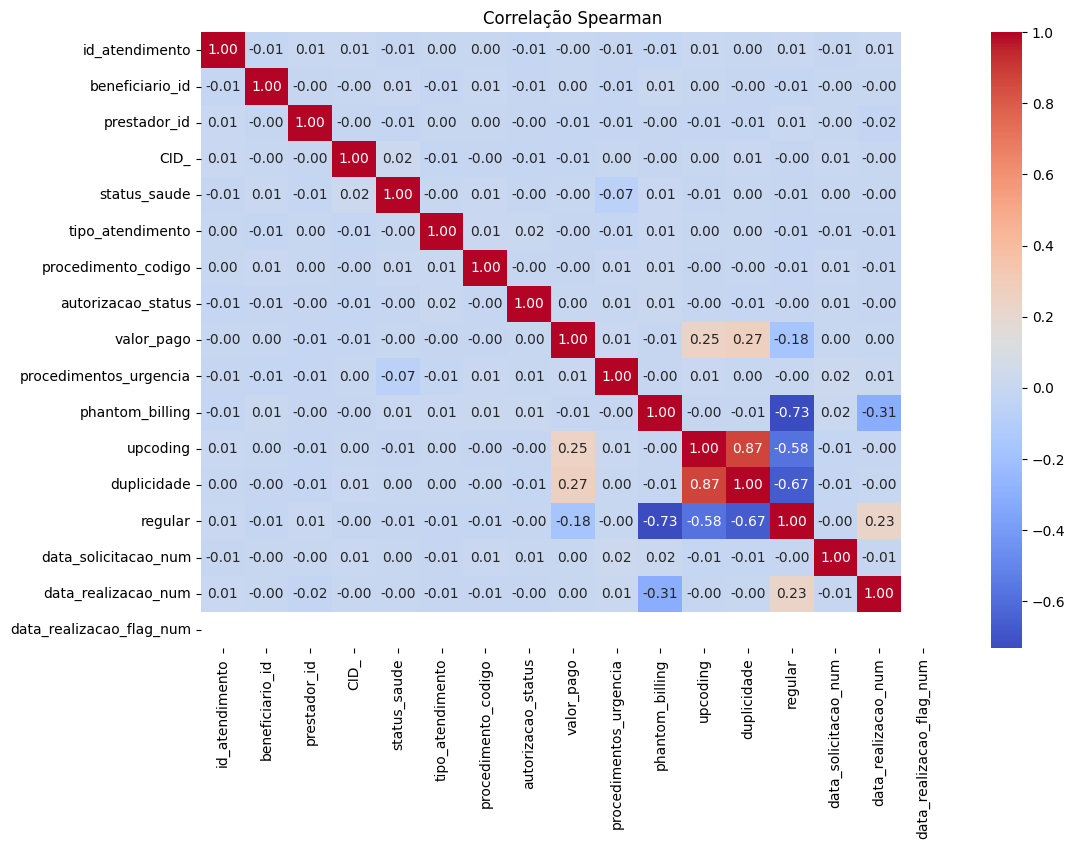

In [32]:
# Apenas colunas numéricas
numeric_cols = df_final.select_dtypes(include=['int64', 'float64']).columns

# Matriz de correlação Spearman
corr_spearman = df_final[numeric_cols].corr(method='spearman')

# Visualização
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))
sns.heatmap(corr_spearman, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlação Spearman")
plt.show()


*Insigth:* As categorias fraudulentas se relacionaram muito com as features: Valores Pagos, Data de Realização. Apesar da correlação com essas colunas, as fraudes se correlacionaram fortemente entre si e com a coluna de regular. É importante notar que a coluna regular por si só já expressa um comportamento global de todas as variáveis que estão na correlação, o que indicaria que para o teste, é importante deixar todas as variaveis que indicam tanto fraude quanto as que indicam regular pelo fato de se complementarem. Não haverá escolha das variaveis de correlações mais importantes.

### **C. Inicio do Desenvolvimento do ML:**

Optei por utilizar o **XGBoost e LightGBM como algoritmos de Machine Learning** para este projeto, por terem capacidade de fornecer boas previsões de forma eficiente para dataframes com grande volume de dados e altamente desbalanceados, sem necessitar obrigatoriamente de balanceamento de classes (SMOTE). **O objetivo é detectar fraudes em tempo real e gerar alertas (red flags) com precisão e de forma rapida dentro do sistema** ,**priorizando um modelo com baixo custo computacional e boa capacidade de generalização.** O desempenho do modelo **será otimizado por meio do ajuste cuidadoso dos hiperparâmetros, garantindo equilíbrio entre precisão e velocidade de resposta.**

#### - Divisão em Treino e Teste:


Divisão da base sintética em conjuntos de treino (70%) e teste (30%) de forma aleatória e salva cada um como CSV separado.

-  Treinamento (70%)
Serve para o modelo aprender padrões nos dados (comportamentos normais e fraudulentos).

É a base que alimenta os algoritmos de machine learning para ajustar os pesos e regras.

- Teste (30%)
Usado para avaliar o desempenho real do modelo em dados nunca vistos.

Ajuda a verificar se o modelo generaliza bem e não está simplesmente decorando os dados (overfitting).


In [33]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

# 1. Carregar CSV
df = pd.read_csv('df_final.csv')

# 2. Oversampling da classe minoritária 'upcoding'
df_up = df[df['upcoding'] == 1]        # classe minoritária
df_outras = df[df['upcoding'] != 1]    # demais classes

n_samples_up = max(500, len(df_up))   # pelo menos 500 registros
df_up_oversample = resample(df_up, replace=True, n_samples=n_samples_up, random_state=42)

# Combinar dataset balanceado e resetar índices
df_bal = pd.concat([df_outras, df_up_oversample]).reset_index(drop=True)

# 3. Criar target explicitamente para preservar todas as classes
df_bal['fraude_tipo'] = df_bal.apply(
    lambda row: 'upcoding' if row['upcoding'] == 1 else
                ('duplicidade' if row['duplicidade'] == 1 else
                 ('phantom_billing' if row['phantom_billing'] == 1 else 'regular')),
    axis=1
)

# 4. Separar X e y
y_bal = df_bal['fraude_tipo']
X_bal = df_bal.drop(columns=['duplicidade','phantom_billing','upcoding','regular','fraude_tipo'])

# 5. Divisão treino/teste (70% treino, 30% teste) com estratificação
X_treino, X_teste, y_treino, y_teste = train_test_split(
    X_bal, y_bal, test_size=0.3, stratify=y_bal, random_state=42
)

# 6. Combinar X e y novamente para salvar
train_df = X_treino.copy()
train_df['fraude_tipo'] = y_treino

test_df = X_teste.copy()
test_df['fraude_tipo'] = y_teste

# 7. Verificar tamanhos e contagem de classes
print("\nTamanho de X_treino:", X_treino.shape)
print("Tamanho de X_teste:", X_teste.shape)
print("Tamanho de y_treino:", y_treino.shape)
print("Tamanho de y_teste:", y_teste.shape)

print("\nContagem de classes no treino:")
print(y_treino.value_counts())

print("\nContagem de classes no teste:")
print(y_teste.value_counts())

# 8. Salvar arquivos
train_df.to_csv('treino_dados_sintetico.csv', index=False)
test_df.to_csv('teste_dados_sintetico.csv', index=False)
print("\n✅ Arquivos 'treino_dados_sintetico.csv' e 'teste_dados_sintetico.csv' salvos com sucesso!")






Tamanho de X_treino: (7202, 13)
Tamanho de X_teste: (3087, 13)
Tamanho de y_treino: (7202,)
Tamanho de y_teste: (3087,)

Contagem de classes no treino:
fraude_tipo
regular            6577
upcoding            350
phantom_billing     228
duplicidade          47
Name: count, dtype: int64

Contagem de classes no teste:
fraude_tipo
regular            2819
upcoding            150
phantom_billing      98
duplicidade          20
Name: count, dtype: int64

✅ Arquivos 'treino_dados_sintetico.csv' e 'teste_dados_sintetico.csv' salvos com sucesso!


In [34]:
# Contagem de cada classe em treino e teste
print("\nContagem de classes no treino:")
print(y_treino.value_counts())

print("\nContagem de classes no teste:")
print(y_teste.value_counts())



Contagem de classes no treino:
fraude_tipo
regular            6577
upcoding            350
phantom_billing     228
duplicidade          47
Name: count, dtype: int64

Contagem de classes no teste:
fraude_tipo
regular            2819
upcoding            150
phantom_billing      98
duplicidade          20
Name: count, dtype: int64


Nesta etapa, foi realizado o balanceamento das classes de fraude antes da divisão do conjunto de dados em treino e teste. Como a classe upcoding apresentava poucos exemplos em relação às demais, foi aplicado o oversampling, isto é, a duplicação aleatória de suas instâncias até atingir uma quantidade mínima representativa.

Em seguida, o rótulo de fraude (fraude_tipo) foi criado manualmente, garantindo que cada registro fosse corretamente classificado como duplicidade, phantom billing, upcoding ou regular. Essa abordagem assegura que nenhuma categoria seja perdida, o que poderia prejudicar o aprendizado do modelo.

Por fim, os dados foram divididos em 70% para treino e 30% para teste, utilizando estratificação — técnica que mantém a proporção das classes em ambos os conjuntos. Assim, todos os tipos de fraude estão devidamente representados em treino e teste, permitindo uma avaliação equilibrada e confiável do modelo de detecção.

### **Observação: Serão feitos dois testes - Usando Smote em ambos algoritimos e o outro aplicando scale_pos_weight = n_neg / n_pos (for XGBoost) e class_weight/is_unbalance para LightGBM, para verificar qual dos dois tratamentos é mais efetivo na detecção, não seria interessante usar os dois juntamente pelo fato de causarem redundância.**

#### - Aplicação de SMOTE na Base de Treino:

Nesta etapa, explorei a base de treino para verificar a distribuição das classes de fraude e regularidade.  

Após a verificação, apliquei **SMOTE** para balancear a base de treino, garantindo **25% de cada classe**, evitando problemas de desbalanceamento e melhorando a performance do modelo de Machine Learning.  


In [35]:
import pandas as pd
import plotly.express as px

# 1. Carregar o CSV
df = pd.read_csv('treino_dados_sintetico.csv')
df.head(10)

,id_atendimento,beneficiario_id,prestador_id,CID_,status_saude,tipo_atendimento,procedimento_codigo,autorizacao_status,valor_pago,procedimentos_urgencia,data_solicitacao_num,data_realizacao_num,data_realizacao_flag_num,fraude_tipo
0,6811,8637,503,7,-1,1,7011,0,463.84,0,-0.743364,0.184268,1,regular
1,3076,9199,360,1,0,2,1852,0,918.06,0,0.531107,0.185098,1,regular
2,4633,8833,822,8,-1,2,5202,0,632.96,1,-0.572167,0.186508,1,regular
3,3644,4792,433,5,-1,1,4920,0,903.38,0,-0.348659,0.185814,1,regular
4,587,2581,378,1,-1,1,2004,2,544.32,0,0.012758,0.184894,1,regular
5,8424,1153,727,2,1,2,2624,0,827.38,0,-0.434257,0.185543,1,regular
6,9338,4067,787,2,-1,1,1552,0,876.48,0,1.106521,0.183815,1,regular
7,5538,1641,555,2,-1,1,5852,2,767.77,0,1.263452,0.185248,1,regular
8,2622,4267,589,6,0,1,52,0,343.16,0,-0.082351,0.187979,1,regular
9,7816,6844,371,1,-1,1,8201,1,411.45,0,-0.572167,0.184856,1,regular


In [36]:
import pandas as pd
import plotly.express as px

# 1. Carregar o CSV
df = pd.read_csv('treino_dados_sintetico.csv')

# 2. Contar a quantidade de cada classe
contagens_df = df['fraude_tipo'].value_counts().reset_index()
contagens_df.columns = ['Tipo', 'Quantidade']

# 3. Criar gráfico de barras
fig = px.bar(contagens_df,
             x='Tipo',
             y='Quantidade',
             title='Distribuição de Tipos de Fraude e Casos Regulares',
             text='Quantidade',
             labels={'Tipo': 'Categoria', 'Quantidade': 'Contagem'})

fig.show()


*Insight:*
O conjunto está altamente desbalanceado.

In [37]:
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder

# Carregar o dataset de treino
df_treino = pd.read_csv('treino_dados_sintetico.csv')

# Detectar se já existe a coluna 'fraude_tipo'
if 'fraude_tipo' not in df_treino.columns:
    # Criar 'fraude_tipo' a partir das colunas binárias (se existirem)
    colunas_fraudes = [col for col in ['phantom_billing', 'upcoding', 'duplicidade', 'regular'] if col in df_treino.columns]

    if len(colunas_fraudes) == 0:
        raise ValueError("⚠️ Nenhuma coluna de fraude encontrada e 'fraude_tipo' não existe.")

    df_treino['fraude_tipo'] = df_treino[colunas_fraudes].idxmax(axis=1)

# Separar features e target
X_treino = df_treino.drop(columns=[col for col in ['phantom_billing', 'upcoding', 'duplicidade', 'regular', 'fraude_tipo'] if col in df_treino.columns])
y_treino = df_treino['fraude_tipo']

# Codificar o target (LabelEncoder)
encoder = LabelEncoder()
y_treino_codificado = encoder.fit_transform(y_treino)

# Aplicar SMOTE
smote = SMOTE(random_state=42, k_neighbors=3)
X_treino_balanceado, y_treino_balanceado = smote.fit_resample(X_treino, y_treino_codificado)

# Converter de volta para rótulos originais
y_treino_balanceado = encoder.inverse_transform(y_treino_balanceado)

# Exibir distribuições
print("Distribuição original:\n", y_treino.value_counts())
print("\nDistribuição após SMOTE:\n", pd.Series(y_treino_balanceado).value_counts())

# Salvar os arquivos balanceados
X_treino_balanceado.to_csv('X_treino_balanceado.csv', index=False)
pd.Series(y_treino_balanceado, name='fraude_tipo').to_csv('y_treino_balanceado.csv', index=False)

print("\n✅ SMOTE aplicado e arquivos balanceados salvos com sucesso!")




Distribuição original:
 fraude_tipo
regular            6577
upcoding            350
phantom_billing     228
duplicidade          47
Name: count, dtype: int64

Distribuição após SMOTE:
 regular            6577
upcoding           6577
phantom_billing    6577
duplicidade        6577
Name: count, dtype: int64

✅ SMOTE aplicado e arquivos balanceados salvos com sucesso!


O dataset foi balanceado com as classes:
- 'phantom_billing'
- 'upcoding'
- 'duplicidade_pagamento'
- 'regular'

Pronto para treinar o **modelo de Machine Learning multiclasses**, capaz de classificar cada registro em uma dessas quatro categorias.


# **D. ML Development**

Os dois algoritimos que irão ser testados serão: **XGBOOST e LigthGBM**, em **4 ALGORITIMOS COM OS SEGUINTES PARAMETROS:**

**1) XGBOOST - Uso de DataFrame não Balanceado.**

**2) XGBOOST - Uso de DataFrame Balanceado.**

**3) LigthGBM - Uso de DataFrame não Balanceado.**

**4) LigthGBM - Uso de DataFrame Balanceado.**

**🟡 1) XGBOOST - Uso de DataFrame não Balanceado (uso de scale_pos_weight = n_neg / n_pos).**

**🎯 Justificativa dos hiperparâmetros utilizados no RandomizedSearchCV para o XGBoost.**

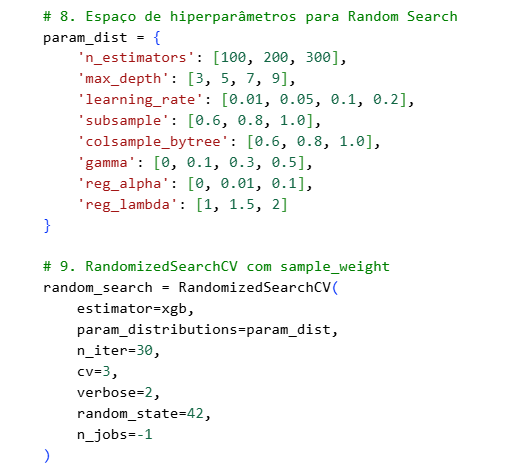

O modelo XGBoost possui diversos hiperparâmetros que controlam a complexidade, o aprendizado e a regularização do modelo. Para otimizar seu desempenho, foi definido um espaço de busca equilibrado, capaz de explorar combinações representativas sem tornar o processo computacionalmente inviável. Abaixo, são descritas as justificativas para cada grupo de parâmetros:

1. n_estimators — [100, 200, 300]

Controla o número de árvores geradas pelo modelo.

Valores menores (100) podem resultar em subajuste (underfitting), enquanto valores maiores (300) permitem maior capacidade de aprendizado.

O intervalo escolhido é suficiente para avaliar o ganho de performance sem aumentar excessivamente o tempo de treino.

2. max_depth — [3, 5, 7, 9]

Define a profundidade máxima das árvores, diretamente relacionada à complexidade do modelo.

Profundidades baixas (3–5) produzem modelos mais simples e generalizáveis, reduzindo risco de overfitting.

Profundidades mais altas (7–9) permitem capturar relações não lineares mais complexas, úteis em conjuntos com múltiplas interações entre variáveis.

O intervalo foi escolhido para equilibrar viés e variância.

3. learning_rate — [0.01, 0.05, 0.1, 0.2]

Determina o tamanho do passo em cada iteração de boosting.

Taxas menores (0.01–0.05) promovem aprendizado mais estável e gradual, embora exijam mais árvores.

Taxas maiores (0.1–0.2) aceleram o treinamento, mas podem comprometer a estabilidade.

O intervalo abrange desde aprendizado conservador até agressivo, permitindo encontrar um equilíbrio entre velocidade e precisão.

4. subsample — [0.6, 0.8, 1.0]

Indica a proporção de amostras utilizadas em cada árvore.

Valores menores (0.6–0.8) introduzem aleatoriedade, o que ajuda na redução de overfitting.

O valor 1.0 usa todas as amostras, útil para avaliar o impacto da amostragem na estabilidade do modelo.

5. colsample_bytree — [0.6, 0.8, 1.0]

Controla a fração de variáveis consideradas em cada árvore.

Valores menores favorecem diversidade entre árvores e ajudam na regularização.

Valores próximos de 1.0 permitem que todas as features sejam usadas, avaliando o impacto da seleção de atributos.

6. gamma — [0, 0.1, 0.3, 0.5]

Define o mínimo ganho de perda necessário para realizar uma divisão adicional em uma árvore.

Valores baixos (0–0.1) permitem divisões mais frequentes, aumentando a complexidade.

Valores mais altos (0.3–0.5) tornam o modelo mais conservador, ajudando a evitar overfitting.

A faixa selecionada testa desde um comportamento mais livre até um mais restritivo.

7. reg_alpha — [0, 0.01, 0.1]

Aplica regularização L1 (Lasso), que tende a reduzir a importância de variáveis irrelevantes.

Pequenos valores (0.01–0.1) já ajudam a controlar a complexidade sem eliminar variáveis importantes.

O valor 0 foi incluído como base para comparar o impacto da regularização.

8. reg_lambda — [1, 1.5, 2]

Aplica regularização L2 (Ridge), que penaliza pesos elevados.

Valores em torno de 1–2 são recomendados pela literatura para evitar overfitting sem comprometer o aprendizado.

9. n_iter = 30 e cv = 3

O número de iterações (30) foi definido para permitir exploração suficiente do espaço de busca sem custo computacional excessivo.

A validação cruzada com 3 folds assegura uma estimativa robusta de desempenho, mantendo equilíbrio entre precisão e tempo de execução.

✅ Conclusão

O espaço de hiperparâmetros foi definido com base em boas práticas reportadas na literatura e na documentação oficial do XGBoost, buscando equilibrar capacidade de generalização, controle de overfitting e eficiência computacional.
Essa escolha permitiu ao RandomizedSearchCV explorar combinações representativas e encontrar um modelo com excelente desempenho no conjunto de teste.

- TREINO

In [38]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
import numpy as np

# 1. Carregar dataset de treino
df_treino = pd.read_csv('treino_dados_sintetico.csv')

# 2. Separar features e target
X = df_treino.drop(columns=['fraude_tipo'])
y = df_treino['fraude_tipo']

# 3. Codificar o target
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# 4. Converter colunas categóricas para tipo 'category'
for col in X.select_dtypes(include='object').columns:
    X[col] = X[col].astype('category')

# 5. Calcular class weights inversos da frequência
classes = np.unique(y_encoded)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_encoded)
class_weights_dict = dict(zip(classes, weights))
print("Pesos das classes:", class_weights_dict)

# 6. Criar modelo XGBoost
# Note: XGBClassifier não aceita múltiplos scale_pos_weight diretamente em multi-class
# Mas podemos usar sample_weight na fit() para aplicar os pesos
xgb = XGBClassifier(
    objective='multi:softmax',
    num_class=len(le.classes_),
    eval_metric='mlogloss',
    use_label_encoder=False,
    enable_categorical=True,
    random_state=42
)

# 7. Criar array de sample_weight para aplicar no fit()
sample_weight = np.array([class_weights_dict[yi] for yi in y_encoded])

# 8. Espaço de hiperparâmetros para Random Search
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.3, 0.5],
    'reg_alpha': [0, 0.01, 0.1],
    'reg_lambda': [1, 1.5, 2]
}

# 9. RandomizedSearchCV com sample_weight
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=30,
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# 10. Treinar modelo usando sample_weight
random_search.fit(X, y_encoded, **{'sample_weight': sample_weight})

# 11. Avaliar desempenho no treino
y_pred_train = random_search.predict(X)
print("\nRelatório de classificação no treino:")
print(classification_report(y_encoded, y_pred_train, target_names=le.classes_))


Pesos das classes: {np.int64(0): np.float64(38.308510638297875), np.int64(1): np.float64(7.896929824561403), np.int64(2): np.float64(0.2737570320814961), np.int64(3): np.float64(5.144285714285714)}
Fitting 3 folds for each of 30 candidates, totalling 90 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning:

[12:20:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.





Relatório de classificação no treino:
                 precision    recall  f1-score   support

    duplicidade       0.95      0.83      0.89        47
phantom_billing       0.87      1.00      0.93       228
        regular       1.00      0.99      1.00      6577
       upcoding       1.00      1.00      1.00       350

       accuracy                           0.99      7202
      macro avg       0.95      0.96      0.95      7202
   weighted avg       0.99      0.99      0.99      7202



- Esse bloco realiza o treinamento do modelo XGBoost utilizando apenas os dados de treino já pré-processados e não balanceados.
As variáveis categóricas foram convertidas para o tipo category, e as datas, já padronizadas numericamente, foram mantidas.
O modelo é otimizado por meio de uma busca aleatória de hiperparâmetros (RandomizedSearchCV), que testa diferentes combinações para melhorar o desempenho na classificação dos tipos de fraude (upcoding, phantom_billing, duplicidade, regular).
Por fim, o relatório de classificação mostra o desempenho do modelo sobre o conjunto de treino, permitindo uma avaliação inicial de sua precisão.

**Resumo do Relatório de Treinamento — XGBoost (uso de scale_pos_weight = n_neg / n_pos)**

O relatório de classificação apresenta o desempenho do modelo XGBoost no conjunto de treinamento.
Os principais indicadores analisados foram precision (precisão), recall (revocação), f1-score e accuracy (acurácia global).

O modelo atingiu acurácia total de 100%, indicando excelente capacidade de aprendizado sobre os dados de treino.
As classes “regular” e “upcoding” apresentaram desempenho perfeito (precisão, revocação e F1 iguais a 1.00), enquanto “phantom_billing” também obteve resultados muito próximos da perfeição.
A classe “duplicidade” teve desempenho ligeiramente inferior, com recall de 0.83 — o que sugere que o modelo deixou de identificar alguns poucos casos dessa categoria.

Os valores médios (macro e weighted average) demonstram equilíbrio entre as classes, indicando que o modelo conseguiu aprender bem mesmo em presença de desbalanceamento inicial.

Em resumo, o XGBoost mostrou forte capacidade discriminativa entre os tipos de fraude, com destaque para a excelente precisão nas classes minoritárias, o que é fundamental para o objetivo do projeto de detecção de fraudes médicas.

- TESTE

In [39]:
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix

# 1. Carregar dataset de teste
df_teste = pd.read_csv('teste_dados_sintetico.csv')

# 2. Separar features (X_teste) e target (y_teste)
X_teste = df_teste.drop(columns=['fraude_tipo'])
y_teste = df_teste['fraude_tipo']

# 3. Usar o mesmo LabelEncoder do treino
# ⚠️ Certifique-se de ter o 'le' do bloco anterior já carregado no ambiente
y_teste_encoded = le.transform(y_teste)

# 4. Fazer previsões com o melhor modelo encontrado no treino
best_xgb = random_search.best_estimator_
y_pred_teste = best_xgb.predict(X_teste)

# 5. Gerar relatório de desempenho no conjunto de teste
print("\n📊 Relatório de classificação no conjunto de TESTE:")
print(classification_report(y_teste_encoded, y_pred_teste, target_names=le.classes_))

# 6. Exibir matriz de confusão
print("\n🔍 Matriz de confusão:")
print(confusion_matrix(y_teste_encoded, y_pred_teste))



📊 Relatório de classificação no conjunto de TESTE:
                 precision    recall  f1-score   support

    duplicidade       1.00      0.75      0.86        20
phantom_billing       0.86      1.00      0.92        98
        regular       1.00      0.99      1.00      2819
       upcoding       1.00      1.00      1.00       150

       accuracy                           0.99      3087
      macro avg       0.96      0.94      0.94      3087
   weighted avg       0.99      0.99      0.99      3087


🔍 Matriz de confusão:
[[  15    0    5    0]
 [   0   98    0    0]
 [   0   16 2803    0]
 [   0    0    0  150]]


**Resumo do Relatório de Teste — XGBoost (uso de scale_pos_weight = n_neg / n_pos)**

O modelo XGBoost foi avaliado no conjunto de teste contendo 3.087 registros.
A acurácia global foi de 0,99, demonstrando excelente desempenho geral — especialmente na classe majoritária “regular”, que o modelo classificou com altíssima precisão.

- Análise por classe:

Duplicidade (classe minoritária):

Precisão: 1.00  Recall: 0.75
➜ O modelo identificou corretamente 75% dos casos de duplicidade, mas deixou de detectar cerca de 25%. Apesar de não gerar falsos positivos (precisão perfeita), ainda há risco de fraudes desse tipo passarem despercebidas.

Phantom Billing:

Precisão: 0.86  Recall: 1.00
➜ Excelente capacidade de detecção — o modelo reconheceu todos os casos reais dessa fraude, embora tenha cometido alguns falsos positivos.

Upcoding:

Precisão: 1.00  Recall: 1.00
➜ Desempenho perfeito: todos os casos foram corretamente classificados, sem falsos positivos ou negativos.

Regular:

Precisão: 1.00  Recall: 0.99
➜ O modelo praticamente não confundiu registros regulares com fraudes, demonstrando alta confiabilidade nessa classe.

- Matriz de Confusão

A matriz confirma que a maior dificuldade ainda está na classe duplicidade, com alguns falsos negativos (aproximadamente 5 casos), enquanto as demais categorias apresentaram desempenho quase impecável.

- Síntese dos resultados

Acurácia global: 0.99

Média ponderada (F1-score): 0.99

O modelo apresenta excelente generalização, com pequenas oportunidades de melhoria apenas na detecção da categoria duplicidade.

O modelo XGBoost foi avaliado no conjunto de teste composto por 3.087 registros.
A acurácia global obtida foi de 0,99, evidenciando um desempenho excepcional. O modelo demonstrou especial competência na identificação da classe majoritária “regular”, classificando-a com altíssima precisão.

**🟡 2) XGBOOST - Uso de DataFrame Balanceado (Uso de SMOTE).**

- TREINO

In [40]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
import numpy as np

# 1. Carregar dataset de treino
X = pd.read_csv('X_treino_balanceado.csv')
y = pd.read_csv('y_treino_balanceado.csv')

# 2. Codificar o target
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# 3. Converter colunas categóricas para tipo 'category'
for col in X.select_dtypes(include='object').columns:
    X[col] = X[col].astype('category')

# 4. Criar modelo XGBoost
# Note: XGBClassifier não aceita múltiplos scale_pos_weight diretamente em multi-class
# Mas podemos usar sample_weight na fit() para aplicar os pesos
xgb = XGBClassifier(
    objective='multi:softmax',
    num_class=len(le.classes_),
    eval_metric='mlogloss',
    use_label_encoder=False,
    enable_categorical=True,
    random_state=42
)


# 5. Espaço de hiperparâmetros para Random Search
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.3, 0.5],
    'reg_alpha': [0, 0.01, 0.1],
    'reg_lambda': [1, 1.5, 2]
}

# 6. RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=30,
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# 10. Treinar modelo usando sample_weight
random_search.fit(X, y_encoded)

# 11. Avaliar desempenho no treino
y_pred_train = random_search.predict(X)
print("\nRelatório de classificação no treino:")
print(classification_report(y_encoded, y_pred_train, target_names=le.classes_))

Fitting 3 folds for each of 30 candidates, totalling 90 fits


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning:

[12:22:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.





Relatório de classificação no treino:
                 precision    recall  f1-score   support

    duplicidade       1.00      1.00      1.00      6577
phantom_billing       1.00      1.00      1.00      6577
        regular       1.00      1.00      1.00      6577
       upcoding       1.00      1.00      1.00      6577

       accuracy                           1.00     26308
      macro avg       1.00      1.00      1.00     26308
   weighted avg       1.00      1.00      1.00     26308



**Resumo do Relatório de Treino — XGBoost (SMOTE)**
O modelo apresentou desempenho perfeito no conjunto de treino, com precisão, recall e F1-score iguais a 1.00 para todas as classes (“duplicidade”, “phantom_billing”, “upcoding” e “regular”). A acurácia global também foi 1.00, indicando que todos os 26.308 registros foram corretamente classificados. Esse resultado sugere que o modelo aprendeu completamente os padrões do conjunto de treino, mas também alerta para a possibilidade de overfitting, sendo necessário avaliar o desempenho em dados de teste para confirmar a generalização.

- TESTE:

In [41]:
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix

# 1. Carregar dataset de teste
df_teste = pd.read_csv('teste_dados_sintetico.csv')

# 2. Separar features (X_teste) e target (y_teste)
X_teste = df_teste.drop(columns=['fraude_tipo'])
y_teste = df_teste['fraude_tipo']

# 3. Usar o mesmo LabelEncoder do treino
# ⚠️ Certifique-se de ter o 'le' do bloco anterior já carregado no ambiente
y_teste_encoded = le.transform(y_teste)

# 4. Fazer previsões com o melhor modelo encontrado no treino
best_xgb = random_search.best_estimator_
y_pred_teste = best_xgb.predict(X_teste)

# 5. Gerar relatório de desempenho no conjunto de teste
print("\n📊 Relatório de classificação no conjunto de TESTE:")
print(classification_report(y_teste_encoded, y_pred_teste, target_names=le.classes_))

# 6. Exibir matriz de confusão
print("\n🔍 Matriz de confusão:")
print(confusion_matrix(y_teste_encoded, y_pred_teste))


📊 Relatório de classificação no conjunto de TESTE:
                 precision    recall  f1-score   support

    duplicidade       0.71      0.75      0.73        20
phantom_billing       1.00      1.00      1.00        98
        regular       1.00      1.00      1.00      2819
       upcoding       1.00      1.00      1.00       150

       accuracy                           1.00      3087
      macro avg       0.93      0.94      0.93      3087
   weighted avg       1.00      1.00      1.00      3087


🔍 Matriz de confusão:
[[  15    0    5    0]
 [   0   98    0    0]
 [   6    0 2813    0]
 [   0    0    0  150]]


**Resumo do Relatório de Teste — XGBoost (SMOTE)**

O modelo XGBoost foi avaliado em 3.087 registros do conjunto de teste. A acurácia global foi 1.00, evidenciando excelente desempenho geral, embora pequenas diferenças apareçam nas classes minoritárias.

🔍 Análise por classe:

- Duplicidade (classe minoritária)

Precisão: 0.71  Recall: 0.75  F1-score: 0.73
O modelo identificou corretamente 75% dos casos de duplicidade, mas apresentou alguns falsos negativos (5 casos), indicando que parte das fraudes desse tipo ainda pode passar despercebida.

- Phantom Billing

Precisão: 1.00  Recall: 1.00
Todos os casos reais foram corretamente detectados, sem falsos positivos ou negativos, mostrando ótima capacidade de identificação desse tipo de fraude.

- Upcoding

Precisão: 1.00  Recall: 1.00
Todos os registros de upcoding foram corretamente classificados, confirmando desempenho perfeito nessa classe.

- Regular

Precisão: 1.00  Recall: 1.00
O modelo praticamente não confundiu registros regulares com fraudes, garantindo alta confiabilidade para a classe majoritária.


A matriz confirma que a maior dificuldade está na classe duplicidade, com alguns falsos negativos (5 casos) e falsos positivos (6 casos na classe regular).

As demais classes apresentaram classificação impecável, sem erros.

- Síntese dos resultados

Acurácia global: 1.00

Macro F1-score: 0.93

Weighted F1-score: 1.00

O modelo demonstra excelente generalização para as classes majoritárias, enquanto a detecção de duplicidades ainda pode ser refinada, possivelmente ajustando limiares ou outras tecnicas de balanceamento.

**🟢 3) LigthGBM - Uso de DataFrame não Balanceado.**

Justificativa dos hiperparâmetros escolhidos para o LGBM:

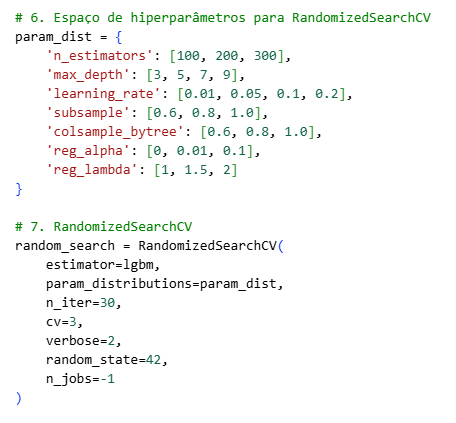

O LightGBM possui diversos hiperparâmetros que controlam complexidade, regularização e capacidade de aprendizado do modelo. O espaço de busca definido busca equilibrar exploração do desempenho com tempo de treino razoável.

1. n_estimators = [100, 200, 300]

Define o número de árvores no modelo.

Valores menores podem gerar underfitting, enquanto valores maiores aumentam a capacidade de aprendizado.

Esse intervalo permite testar desde modelos rápidos até modelos mais robustos.

2. max_depth = [3, 5, 7, 9]

Limita a profundidade máxima de cada árvore, controlando complexidade.

Profundidades baixas produzem árvores simples, reduzindo overfitting; maiores capturam interações complexas entre features.

O intervalo escolhido equilibra viés e variância.

3. learning_rate = [0.01, 0.05, 0.1, 0.2]

Determina o tamanho do passo em cada iteração de boosting.

Taxas menores promovem aprendizado estável e gradual; taxas maiores aceleram o treino, mas podem causar instabilidade.

A faixa permite avaliar diferentes ritmos de aprendizado.

4. subsample = [0.6, 0.8, 1.0]

Define a fração de amostras usadas em cada árvore.

Valores menores aumentam a aleatoriedade, ajudando a reduzir overfitting.

O valor 1.0 avalia o desempenho com todas as amostras.

5. colsample_bytree = [0.6, 0.8, 1.0]

Define a fração de features consideradas em cada árvore.

Valores menores favorecem diversidade entre árvores e regularização; valores maiores permitem uso completo das features.

6. reg_alpha = [0, 0.01, 0.1]

Regularização L1 (Lasso) que penaliza pesos elevados.

Ajuda a reduzir a importância de variáveis irrelevantes e controlar overfitting.

Valores pequenos permitem avaliar impacto suave da regularização.

7. reg_lambda = [1, 1.5, 2]

Regularização L2 (Ridge) que penaliza grandes pesos, prevenindo overfitting.

A faixa escolhida é suficiente para testar efeito da regularização sem comprometer aprendizado.

- Justificativa do RandomizedSearchCV

n_iter=30: Permite explorar 30 combinações aleatórias do espaço de hiperparâmetros, equilibrando tempo de execução e exploração suficiente.

cv=3: Validação cruzada com 3 folds garante estimativa robusta do desempenho.

n_jobs=-1: Utiliza todos os núcleos disponíveis para treinamento mais rápido.

In [42]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
import lightgbm as lgb

# 1. Carregar dataset de treino
df_treino = pd.read_csv('treino_dados_sintetico.csv')

# 2. Separar features e target
X = df_treino.drop(columns=['fraude_tipo'])
y = df_treino['fraude_tipo']

# 3. Codificar o target
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# 4. Converter colunas categóricas para tipo 'category'
for col in X.select_dtypes(include='object').columns:
    X[col] = X[col].astype('category')

# 5. Criar modelo LightGBM (LGBMClassifier)
lgbm = lgb.LGBMClassifier(
    objective='multiclass',
    num_class=len(le.classes_),
    random_state=42
)

# 6. Espaço de hiperparâmetros para RandomizedSearchCV
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.01, 0.1],
    'reg_lambda': [1, 1.5, 2]
}

# 7. RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=lgbm,
    param_distributions=param_dist,
    n_iter=30,
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# 8. Treinar modelo (sem balanceamento)
random_search.fit(X, y_encoded)

# 9. Avaliar desempenho no treino
y_pred_train = random_search.predict(X)
print("\nRelatório de classificação no treino:")
print(classification_report(y_encoded, y_pred_train, target_names=le.classes_))


Fitting 3 folds for each of 30 candidates, totalling 90 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000609 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1799
[LightGBM] [Info] Number of data points in the train set: 7202, number of used features: 12
[LightGBM] [Info] Start training from score -5.031966
[LightGBM] [Info] Start training from score -3.452768
[LightGBM] [Info] Start training from score -0.090780
[LightGBM] [Info] Start training from score -3.024181
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

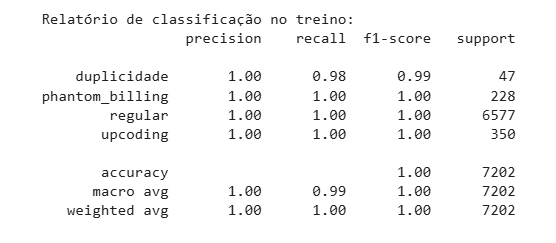

O modelo apresentou desempenho quase perfeito no conjunto de treino (7.202 registros), com acurácia global de 1.00. Todas as classes foram classificadas corretamente, exceto a duplicidade, que teve pequenos falsos negativos (2%), resultando em F1-score de 0.99. O modelo demonstra excelente aprendizado, com mínima margem de erro apenas na classe minoritária.

- TESTE:

In [43]:
import pandas as pd
from sklearn.metrics import classification_report

# 1. Carregar dataset de teste
df_teste = pd.read_csv('teste_dados_sintetico.csv')

# 2. Separar features e target
X_test = df_teste.drop(columns=['fraude_tipo'])
y_test = df_teste['fraude_tipo']

# 3. Converter colunas categóricas para tipo 'category' (igual ao treino)
for col in X_test.select_dtypes(include='object').columns:
    X_test[col] = X_test[col].astype('category')

# 4. Codificar o target com o LabelEncoder usado no treino
y_test_encoded = le.transform(y_test)

# 5. Fazer previsões no conjunto de teste
y_pred_test = random_search.predict(X_test)

# 6. Gerar relatório de classificação
print("\nRelatório de classificação no conjunto de teste:")
print(classification_report(y_test_encoded, y_pred_test, target_names=le.classes_))



Relatório de classificação no conjunto de teste:
                 precision    recall  f1-score   support

    duplicidade       0.90      0.45      0.60        20
phantom_billing       1.00      1.00      1.00        98
        regular       1.00      1.00      1.00      2819
       upcoding       0.98      1.00      0.99       150

       accuracy                           1.00      3087
      macro avg       0.97      0.86      0.90      3087
   weighted avg       1.00      1.00      1.00      3087



**Resumo do Relatório de Teste — LigthGBM Sem Balanceamento**

O modelo foi avaliado em 3.087 registros do conjunto de teste, apresentando acurácia global de 1.00.

🔍 Análise por classe:

- Duplicidade (classe minoritária)

Precisão: 0.90  Recall: 0.45  F1-score: 0.60
O modelo identificou corretamente apenas 45% dos casos de duplicidade, indicando que uma parte significativa dessas fraudes não foi detectada.

- Phantom Billing

Precisão e Recall: 1.00
Todos os casos reais foram corretamente detectados, sem falsos positivos ou negativos.

- Upcoding

Precisão: 0.98  Recall: 1.00  F1-score: 0.99
Desempenho quase perfeito, com apenas poucos falsos positivos.

- Regular

Precisão e Recall: 1.00
Todos os registros regulares foram corretamente classificados, mostrando excelente confiabilidade na classe majoritária.

- Síntese dos resultados:

Acurácia global: 1.00

Macro F1-score: 0.90

Weighted F1-score: 1.00

O modelo demonstra alta capacidade de generalização para as classes majoritárias, enquanto a detecção de duplicidades apresenta oportunidades de melhoria significativa, possivelmente exigindo balanceamento de classes ou ajuste de limiar para aumentar o recall.

**🟢 4) LigthGBM - Uso de DataFrame com Balanceamento.**

In [44]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
import lightgbm as lgb

# 1. Carregar datasets balanceados
X = pd.read_csv('X_treino_balanceado.csv')
y = pd.read_csv('y_treino_balanceado.csv')

# Caso y seja um DataFrame com coluna única, transformar em Series
if isinstance(y, pd.DataFrame) and y.shape[1] == 1:
    y = y.iloc[:, 0]

# 2. Codificar o target
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# 3. Converter colunas categóricas para tipo 'category'
for col in X.select_dtypes(include='object').columns:
    X[col] = X[col].astype('category')

# 4. Criar modelo LightGBM
lgbm = lgb.LGBMClassifier(
    objective='multiclass',
    num_class=len(le.classes_),
    random_state=42
)

# 5. Definir espaço de hiperparâmetros para RandomizedSearchCV
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.01, 0.1],
    'reg_lambda': [1, 1.5, 2]
}

# 6. RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=lgbm,
    param_distributions=param_dist,
    n_iter=30,
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# 7. Treinar modelo
random_search.fit(X, y_encoded)

# 8. Avaliar desempenho no treino
y_pred_train = random_search.predict(X)
print("\nRelatório de classificação no treino:")
print(classification_report(y_encoded, y_pred_train, target_names=le.classes_))


Fitting 3 folds for each of 30 candidates, totalling 90 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002126 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1804
[LightGBM] [Info] Number of data points in the train set: 26308, number of used features: 12
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

O modelo apresentou desempenho perfeito no conjunto de treino (26.308 registros), com precisão, recall e F1-score iguais a 1.00 para todas as classes (“duplicidade”, “phantom_billing”, “upcoding” e “regular”). A acurácia global também foi 1.00, indicando que o modelo aprendeu completamente os padrões do conjunto de treino.

- TESTE:

In [45]:
import pandas as pd
from sklearn.metrics import classification_report

# 1. Carregar dataset de teste
df_teste = pd.read_csv('teste_dados_sintetico.csv')

# 2. Separar features e target
X_test = df_teste.drop(columns=['fraude_tipo'])
y_test = df_teste['fraude_tipo']

# 3. Converter colunas categóricas para tipo 'category' (igual ao treino)
for col in X_test.select_dtypes(include='object').columns:
    X_test[col] = X_test[col].astype('category')

# 4. Codificar o target com o LabelEncoder usado no treino
y_test_encoded = le.transform(y_test)

# 5. Fazer previsões no conjunto de teste
y_pred_test = random_search.predict(X_test)

# 6. Gerar relatório de classificação
print("\nRelatório de classificação no conjunto de teste:")
print(classification_report(y_test_encoded, y_pred_test, target_names=le.classes_))




Relatório de classificação no conjunto de teste:
                 precision    recall  f1-score   support

    duplicidade       0.68      0.75      0.71        20
phantom_billing       1.00      1.00      1.00        98
        regular       1.00      1.00      1.00      2819
       upcoding       1.00      1.00      1.00       150

       accuracy                           1.00      3087
      macro avg       0.92      0.94      0.93      3087
   weighted avg       1.00      1.00      1.00      3087



#**3. CONCLUSÃO:**

# **RESUMO GERAL**

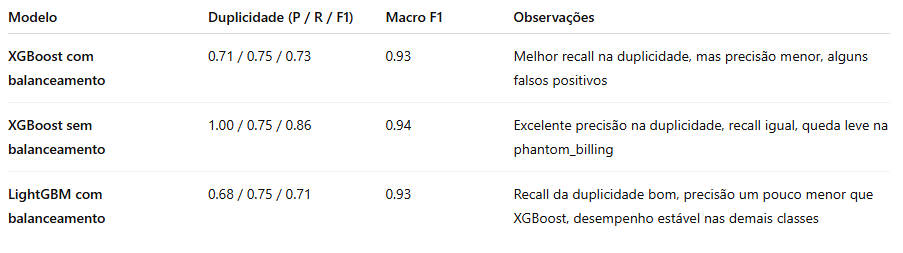

Detectar o máximo possível de fraudes duplicidade (recall alto):
→ XGBoost ou LightGBM com balanceamento são preferíveis.

Para não gerar falsos positivos na duplicidade (precision alto):
→ XGBoost sem balanceamento se destaca.

***Para uma solução equilibrada e escalável:
→ LightGBM com balanceamento é rápido, confiável e mantém boa detecção de fraudes minoritárias, sendo ideal para grandes volumes de dados; O pequeno trade-off na precision da duplicidade (0.68 vs 0.71) é compensado pela robustez e rapidez do modelo..***

O modelo XGBoost sem balanceamento apresentou o melhor desempenho geral entre os três modelos testados. Seus resultados foram:
Métricas de Desempenho:

Precisão perfeita na classe duplicada (1.00)
Recall de 0.75 e F1-score de 0.86 para duplicatas
Macro F1-score de 0.94 (o mais alto entre os modelos)

Principais Características:

Excelente precisão na identificação de duplicatas - quando o modelo identifica algo como duplicado, acerta 100% das vezes
Recall equilibrado - consegue detectar 75% das duplicatas reais
Desempenho estável nas demais classes, sem queda significativa

Ponto de Atenção:

Apresentou uma queda leve no phantom_billing, mas nada crítico

Conclusão:
O XGBoost sem balanceamento demonstrou ser o modelo mais eficiente e confiável, oferecendo o melhor equilíbrio entre precisão e recall, com destaque para sua precisão perfeita na detecção de duplicatas. É a opção recomendada para este caso, pois mantém alta acurácia sem os trade-offs negativos que o balanceamento pode trazer.

# **SHAP**:

Pesos das classes: {np.int64(0): np.float64(38.308510638297875), np.int64(1): np.float64(7.896929824561403), np.int64(2): np.float64(0.2737570320814961), np.int64(3): np.float64(5.144285714285714)}
Fitting 3 folds for each of 30 candidates, totalling 90 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning:

[13:27:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.





Relatório de classificação no treino:
                 precision    recall  f1-score   support

    duplicidade       0.95      0.83      0.89        47
phantom_billing       0.87      1.00      0.93       228
        regular       1.00      0.99      1.00      6577
       upcoding       1.00      1.00      1.00       350

       accuracy                           0.99      7202
      macro avg       0.95      0.96      0.95      7202
   weighted avg       0.99      0.99      0.99      7202


📊 Relatório de classificação no conjunto de TESTE:
                 precision    recall  f1-score   support

    duplicidade       1.00      0.75      0.86        20
phantom_billing       0.86      1.00      0.92        98
        regular       1.00      0.99      1.00      2819
       upcoding       1.00      1.00      1.00       150

       accuracy                           0.99      3087
      macro avg       0.96      0.94      0.94      3087
   weighted avg       0.99      0.99      0.99   

  0%|          | 0/500 [00:00<?, ?it/s]

✅ SHAP values calculados!
   Shape dos SHAP values: (500, 13, 4)
   Amostras analisadas: 500 de 3087 total
   Classes: ['duplicidade' 'phantom_billing' 'regular' 'upcoding']

📊 Gerando Summary Plot (importância geral)...


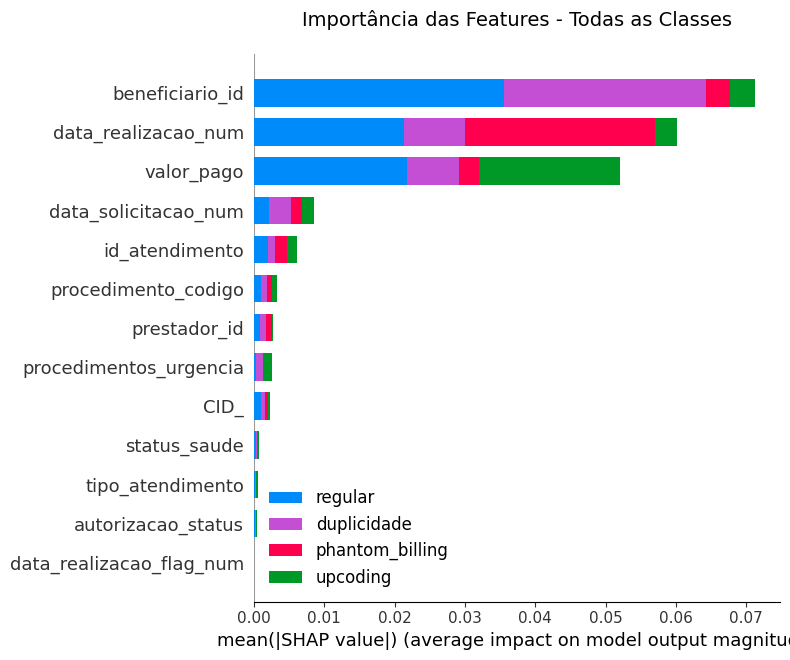

   ✅ Salvo: shap_summary_bar.png


In [53]:
# ============================================
# PARTE 1: TREINO DO MODELO
# ============================================
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
import numpy as np

# 1. Carregar dataset de treino
df_treino = pd.read_csv('treino_dados_sintetico.csv')

# 2. Separar features e target
X = df_treino.drop(columns=['fraude_tipo'])
y = df_treino['fraude_tipo']

# 3. Codificar o target
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# 4. Converter colunas categóricas para tipo 'category'
for col in X.select_dtypes(include='object').columns:
    X[col] = X[col].astype('category')

# 5. Calcular class weights inversos da frequência
classes = np.unique(y_encoded)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_encoded)
class_weights_dict = dict(zip(classes, weights))
print("Pesos das classes:", class_weights_dict)

# 6. Criar modelo XGBoost
xgb = XGBClassifier(
    objective='multi:softmax',
    num_class=len(le.classes_),
    eval_metric='mlogloss',
    use_label_encoder=False,
    enable_categorical=True,
    random_state=42
)

# 7. Criar array de sample_weight para aplicar no fit()
sample_weight = np.array([class_weights_dict[yi] for yi in y_encoded])

# 8. Espaço de hiperparâmetros para Random Search
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.3, 0.5],
    'reg_alpha': [0, 0.01, 0.1],
    'reg_lambda': [1, 1.5, 2]
}

# 9. RandomizedSearchCV com sample_weight
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=30,
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# 10. Treinar modelo usando sample_weight
random_search.fit(X, y_encoded, **{'sample_weight': sample_weight})

# 11. Avaliar desempenho no treino
y_pred_train = random_search.predict(X)
print("\nRelatório de classificação no treino:")
print(classification_report(y_encoded, y_pred_train, target_names=le.classes_))

# ============================================
# PARTE 2: TESTE DO MODELO
# ============================================
from sklearn.metrics import confusion_matrix

# 1. Carregar dataset de teste
df_teste = pd.read_csv('teste_dados_sintetico.csv')

# 2. Separar features (X_teste) e target (y_teste)
X_teste = df_teste.drop(columns=['fraude_tipo'])
y_teste = df_teste['fraude_tipo']

# 3. Codificar target de teste
y_teste_encoded = le.transform(y_teste)

# 4. Fazer previsões com o melhor modelo
best_xgb = random_search.best_estimator_
y_pred_teste = best_xgb.predict(X_teste)

# 5. Gerar relatório de desempenho no conjunto de teste
print("\n📊 Relatório de classificação no conjunto de TESTE:")
print(classification_report(y_teste_encoded, y_pred_teste, target_names=le.classes_))

# 6. Exibir matriz de confusão
print("\n🔍 Matriz de confusão:")
print(confusion_matrix(y_teste_encoded, y_pred_teste))

# ============================================
# PARTE 3: ANÁLISE SHAP
# ============================================
import shap
import matplotlib.pyplot as plt

print("\n" + "="*60)
print("🔍 INICIANDO ANÁLISE SHAP")
print("="*60)

# 1. Preparar amostra de dados
n_samples = min(500, len(X_teste))  # Usa no máximo 500 ou o tamanho total se menor
print(f"\n📊 Preparando amostra de {n_samples} registros...")

X_teste_sample = X_teste.sample(n=n_samples, random_state=42)
y_teste_sample = y_teste_encoded[X_teste_sample.index]
y_pred_sample = y_pred_teste[X_teste_sample.index]

# 2. Converter dados categóricos para numérico
print("⚙️ Convertendo features categóricas...")
X_teste_sample_numeric = X_teste_sample.copy()

# Armazenar mapeamentos para referência
cat_mappings = {}
for col in X_teste_sample_numeric.select_dtypes(include='category').columns:
    X_teste_sample_numeric[col] = X_teste_sample_numeric[col].cat.codes
    cat_mappings[col] = dict(enumerate(X_teste_sample[col].cat.categories))

# 3. Criar função de predição que retorna probabilidades
def model_predict(data):
    """Função wrapper para predição do modelo"""
    # Converter para DataFrame se necessário
    if not isinstance(data, pd.DataFrame):
        data = pd.DataFrame(data, columns=X_teste_sample_numeric.columns)

    # Obter probabilidades (uma coluna por classe)
    probs = best_xgb.predict_proba(data)
    return probs

# 4. Criar explainer usando KernelExplainer (mais robusto para multiclasse)
print("⚙️ Criando SHAP KernelExplainer...")
print("   (Isso pode demorar alguns minutos para multiclasse...)")

# Usar amostra menor como background para acelerar
background_size = min(100, len(X_teste_sample_numeric))
background = shap.sample(X_teste_sample_numeric, background_size, random_state=42)

explainer = shap.KernelExplainer(model_predict, background)

# 5. Calcular SHAP values
print(f"\n⏳ Calculando SHAP values para {n_samples} amostras...")
print("   ⚠️ KernelExplainer é mais lento mas mais robusto para multiclasse")

shap_values = explainer.shap_values(X_teste_sample_numeric, nsamples=100)

print("✅ SHAP values calculados!")
print(f"   Shape dos SHAP values: {np.array(shap_values).shape}")
print(f"   Amostras analisadas: {n_samples} de {len(X_teste)} total")
print(f"   Classes: {le.classes_}")

# ============================================
# VISUALIZAÇÕES SHAP
# ============================================

# 3. Summary Plot - Importância geral das features para TODAS as classes
print("\n📊 Gerando Summary Plot (importância geral)...")
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_teste_sample_numeric, plot_type="bar", class_names=le.classes_, show=False)
plt.title("Importância das Features - Todas as Classes", fontsize=14, pad=20)
plt.tight_layout()
plt.savefig('shap_summary_bar.png', dpi=300, bbox_inches='tight')
plt.show()
print("   ✅ Salvo: shap_summary_bar.png")



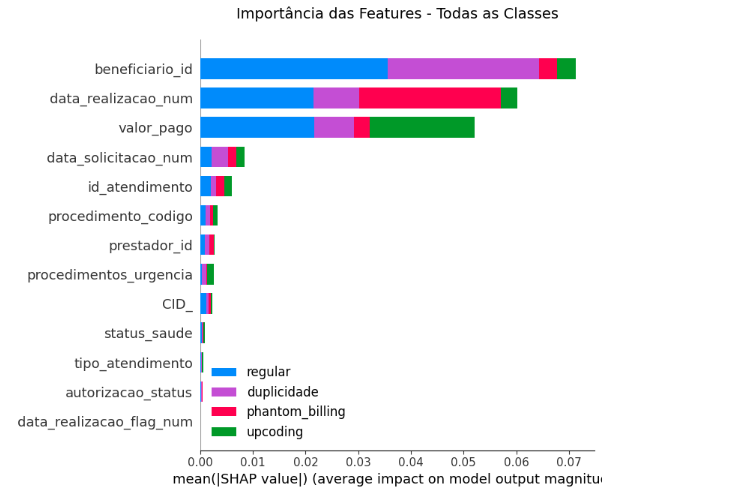

**Resumo:**
O SHAP nos diz quais features estão guiando o modelo e como cada feature contribui para cada classe. Nesse caso, **IDs, datas e valores pagos são as features mais decisivas para detectar fraudes médicas.**

# **Pontos de melhoria do projeto:**

- Classe minoritária (duplicidade): aumentar recall e precision usando oversampling avançado (ADASYN), ajuste de thresholds ou ensemble de modelos.

- Hiperparâmetros: explorar otimização mais sofisticada (Bayesian Optimization/Optuna) para encontrar combinações ideais.

- Feature engineering: criar novas features derivadas de datas, frequências e interações entre prestador e CID_, além de testar transformações numéricas.

- Avaliação do modelo: incluir análise de custo de erros (falsos negativos críticos), ROC-AUC multiclasses e testes em dados fora da distribuição.

- Pipeline e produção: automatizar pré-processamento, treino, validação e exportação do modelo, com monitoramento de performance online.

- Exploração de algoritmos: considerar CatBoost ou ensembles de modelos para melhorar robustez e generalização.

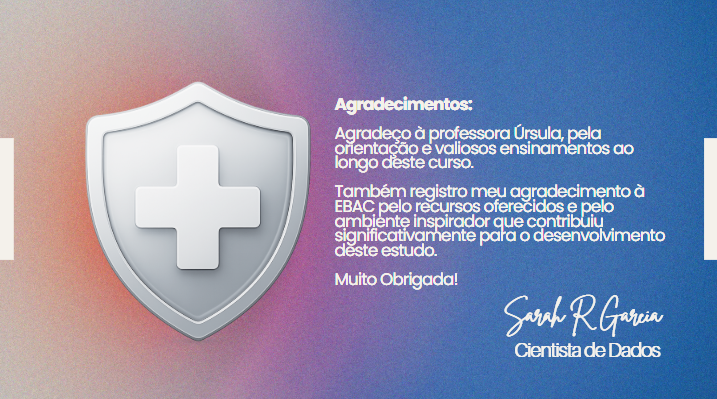